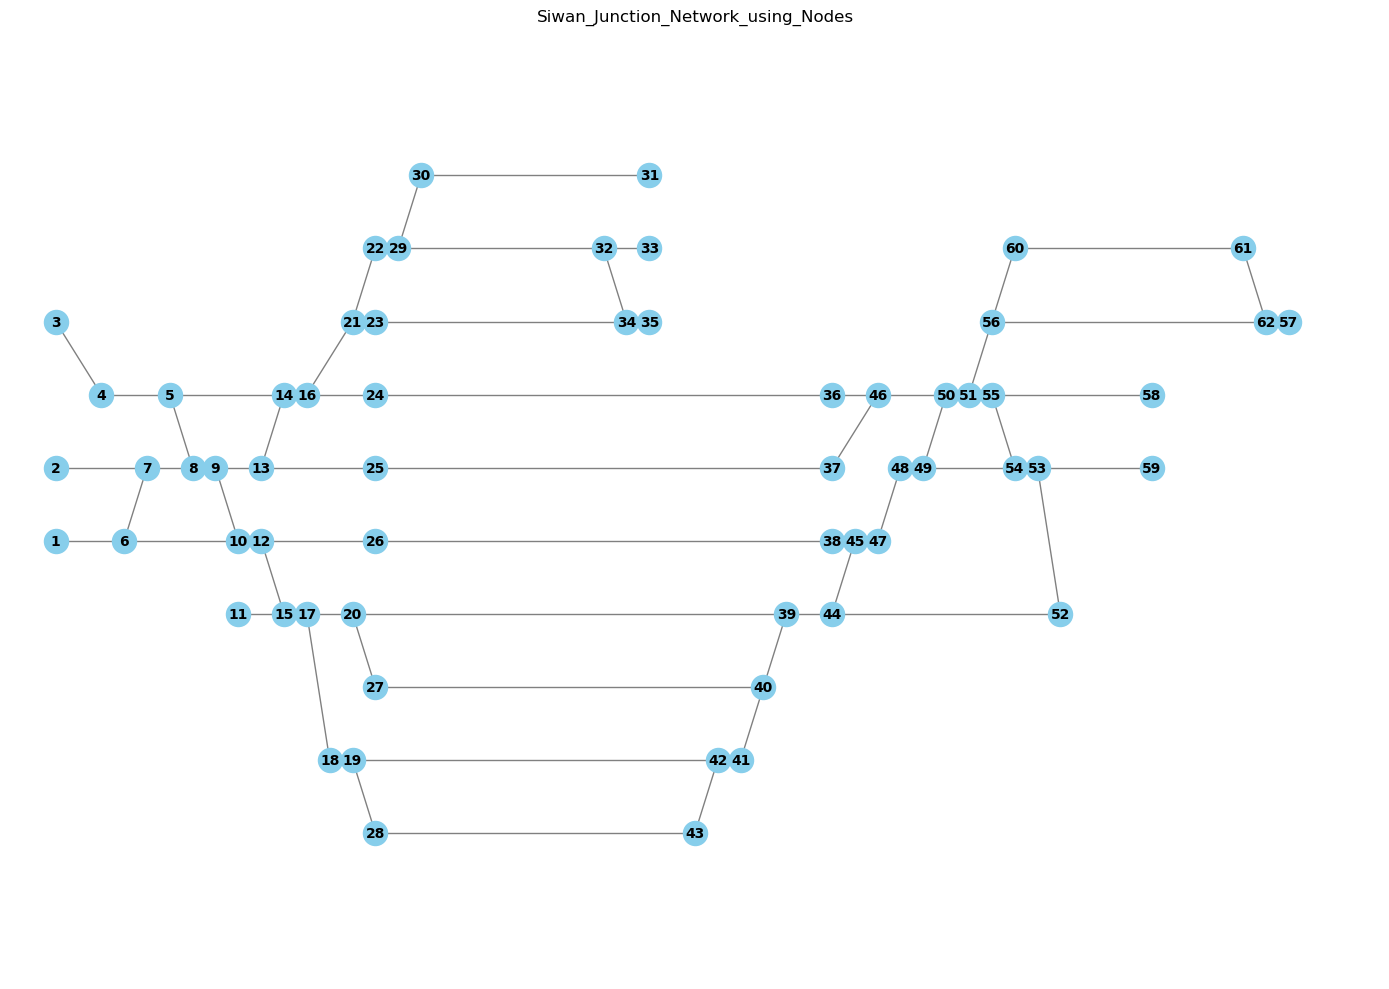

In [8]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker

# Load CSV data
df = pd.read_csv('Book-(Sheet1).csv')

# Build the network graph
G = nx.Graph()
for _, row in df.iterrows():
    G.add_node(row['nodes'], pos=(row['x'], row['y']))
    adjacent = str(row['adjacent_connected_node(s)']).replace('"','').split(',')
    for adj in adjacent:
        adj = int(adj.strip())
        if not G.has_edge(row['nodes'], adj):
            G.add_edge(row['nodes'], adj)

# Draw the graph
pos = nx.get_node_attributes(G, 'pos')
fig, ax = plt.subplots(figsize=(14, 10))
nx.draw(G, pos, ax=ax, with_labels=True, node_size=300, node_color='skyblue', font_size=10, font_weight='bold', edge_color='gray')

# Set grid with 1cm spacing using MultipleLocator
locator = plticker.MultipleLocator(base=1)
ax.xaxis.set_major_locator(locator)
ax.yaxis.set_major_locator(locator)

# Draw grid lines clearly
ax.grid(which='major', linestyle='--', linewidth=0.7, color='gray')

# Expand axis limits to include all visible ticks/nodes
ax.set_xlim(min(df['x'].min()-1, 0), df['x'].max() + 2)
ax.set_ylim(min(df['y'].min()-1, 0), df['y'].max() + 2)

# Axis labels for clarity
ax.set_xlabel('X (cm)')
ax.set_ylabel('Y (cm)')
plt.title('Siwan_Junction_Network_using_Nodes')
plt.tight_layout()
plt.grid()
plt.show()


In [20]:
# full_simulation_with_uploaded_csv.py
import csv
import math
import random
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib as mpl
from datetime import datetime, timedelta

# -------------------------
# CONFIGURATION
# -------------------------
CSV_FILE = "/mnt/data/Book-(Sheet1).csv"   # uploaded file path
START_TIME = datetime(2025, 8, 12, 12, 0, 0)

# headways (minutes)
SECTION_HEADWAY = 2.0
SWITCH_HEADWAY = 5.0
PLATFORM_HEADWAY = 1.0

DWELL_STOP = 5.0
DWELL_PASS = 0.0

MIN_TRAVEL_TIME = 0.01   # minutes (~0.6 sec)
SPEED_KM_H = 40.0        # used to derive travel time from coords if needed

# all-to-all generation mode: "all", "sample", or "pairs_list"
ALL_TO_ALL_MODE = "sample"
MAX_TRAINS = 40         # safety cap (or sample size)
INJECTION_GAP_MIN = 1.0 # minutes between injected trains

# animation/playback settings
FRAMES_PER_MIN = 10
SIM_DURATION_MIN = 120  # playback window in minutes
FRAME_INTERVAL_MS = 70

DEBUG = True
RANDOM_SEED = 42
random.seed(RANDOM_SEED)

# -------------------------
# Load CSV and build graph
# -------------------------
G = nx.Graph()
csv_loaded = False
with open(CSV_FILE, newline='', encoding='utf-8') as f:
    reader = csv.DictReader(f)
    headers = reader.fieldnames
    if headers is None:
        raise ValueError("CSV appears empty or malformed.")
    # Column names according to your uploaded file
    node_col = 'nodes'   # you confirmed this column exists
    x_col = 'x'
    y_col = 'y'
    adj_col = 'adjacent_connected_node(s)'

    for row in reader:
        node = str(row[node_col]).strip()
        try:
            x = float(row[x_col])
            y = float(row[y_col])
        except Exception as e:
            raise ValueError(f"Invalid coordinates for node {node}: {e}")
        G.add_node(node, x=x, y=y)

        # parse adjacency: allow comma, semicolon, space, may have trailing commas
        raw_adj = str(row.get(adj_col, "")).strip()
        if raw_adj:
            # replace quotes and split by comma/semicolon/space
            raw_adj = raw_adj.replace('"', '').replace("'", "")
            sep = ',' if ',' in raw_adj else ';' if ';' in raw_adj else ' '
            for tok in [t.strip() for t in raw_adj.split(sep) if t.strip()]:
                G.add_edge(node, tok)
    csv_loaded = True

if not csv_loaded:
    raise RuntimeError("Failed to load CSV")

if DEBUG:
    print(f"Loaded graph: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")

# -------------------------
# Travel time helpers
# -------------------------
def euclidean_m(u, v):
    xu, yu = G.nodes[u]['x'], G.nodes[u]['y']
    xv, yv = G.nodes[v]['x'], G.nodes[v]['y']
    return math.hypot(xv - xu, yv - yu)

def travel_minutes_from_coords(u, v):
    # convert speed to m/min
    speed_m_per_min = (SPEED_KM_H * 1000.0) / 60.0
    d_m = euclidean_m(u, v)
    t_min = d_m / speed_m_per_min
    if t_min < MIN_TRAVEL_TIME and DEBUG:
        print(f"🚧 Debug: Edge {u}->{v} very small travel_time = {t_min:.6f} min -> forcing minimum {MIN_TRAVEL_TIME:.6f} min")
    return max(t_min, MIN_TRAVEL_TIME)

def is_switch(node):
    return G.degree(node) >= 3

# -------------------------
# Build OD pairs (all/sample/pairs_list)
# -------------------------
nodes = list(G.nodes)
pairs = []

if ALL_TO_ALL_MODE == "all":
    for s in nodes:
        for d in nodes:
            if s != d:
                pairs.append((s, d))
    if len(pairs) > MAX_TRAINS:
        if DEBUG:
            print(f"⚠ Too many pairs ({len(pairs)}). Truncating to {MAX_TRAINS}.")
        pairs = pairs[:MAX_TRAINS]

elif ALL_TO_ALL_MODE == "sample":
    full_pairs = [(s, d) for s in nodes for d in nodes if s != d]
    if len(full_pairs) <= MAX_TRAINS:
        pairs = full_pairs
    else:
        pairs = random.sample(full_pairs, MAX_TRAINS)

elif ALL_TO_ALL_MODE == "pairs_list":
    # Example placeholder: replace with your desired pairs
    pairs_list = [("2", "58"), ("3", "58"), ("59", "1")]
    pairs = [p for p in pairs_list if p[0] in nodes and p[1] in nodes and p[0] != p[1]]

else:
    raise ValueError("Invalid ALL_TO_ALL_MODE")

if DEBUG:
    print(f"Generating {len(pairs)} trips (mode={ALL_TO_ALL_MODE})")

# -------------------------
# Train class & scheduling
# -------------------------
class Train:
    def __init__(self, tid, route, start_dt, is_stopping=True):
        self.tid = tid
        self.route = route[:]  # list of node ids
        self.start_dt = start_dt
        self.is_stopping = is_stopping
        self.path_log = []     # list of {'node','arrival','departure','x','y','stopping'}
        self.sections_used = []  # list of (u,v,start_dt,end_dt)

def schedule_trains(pairs, injection_gap_min=INJECTION_GAP_MIN):
    trains = []
    section_free = {}   # frozenset({u,v}) -> datetime when free
    switch_free = {}    # node -> datetime when free
    platform_free = {}  # node -> datetime when free

    next_injection_time = START_TIME
    tid = 0
    for s, d in pairs:
        tid += 1
        # find shortest path (by hop-count). If you want weighted path use weight param.
        try:
            route = nx.shortest_path(G, s, d)
        except nx.NetworkXNoPath:
            if DEBUG:
                print(f"⚠ No path {s}->{d}, skipping.")
            continue

        train = Train(tid, route, start_dt=next_injection_time, is_stopping=(random.random() < 0.7))
        time_cursor = next_injection_time

        for i, node in enumerate(route):
            x, y = G.nodes[node]['x'], G.nodes[node]['y']
            arrival = time_cursor
            dwell = DWELL_STOP if train.is_stopping else DWELL_PASS
            departure = arrival + timedelta(seconds=dwell * 60)

            # enforce platform headway
            pf = platform_free.get(node, START_TIME)
            if arrival < pf:
                arrival = pf
                departure = arrival + timedelta(seconds=dwell * 60)

            platform_free[node] = departure + timedelta(seconds=PLATFORM_HEADWAY * 60)

            # log node occupancy
            train.path_log.append({'node': node, 'arrival': arrival, 'departure': departure,
                                   'x': x, 'y': y, 'stopping': train.is_stopping})

            # if moving to next node, compute travel and enforce section/switch headways
            if i < len(route) - 1:
                u, v = node, route[i+1]
                travel_min = travel_minutes_from_coords(u, v)

                section_key = frozenset({u, v})
                sec_free = section_free.get(section_key, START_TIME)
                if departure < sec_free:
                    departure = sec_free
                    platform_free[node] = departure + timedelta(seconds=PLATFORM_HEADWAY * 60)
                    train.path_log[-1]['departure'] = departure

                if is_switch(u):
                    sw_free = switch_free.get(u, START_TIME)
                    if departure < sw_free:
                        departure = sw_free
                        platform_free[node] = departure + timedelta(seconds=PLATFORM_HEADWAY * 60)
                        train.path_log[-1]['departure'] = departure
                if is_switch(v):
                    sw_free = switch_free.get(v, START_TIME)
                    if departure < sw_free:
                        departure = sw_free
                        platform_free[node] = departure + timedelta(seconds=PLATFORM_HEADWAY * 60)
                        train.path_log[-1]['departure'] = departure

                start_move = departure
                arrival_next = start_move + timedelta(seconds=travel_min * 60)

                train.sections_used.append((u, v, start_move, arrival_next))

                # update frees
                section_free[section_key] = arrival_next + timedelta(seconds=SECTION_HEADWAY * 60)
                if is_switch(u):
                    switch_free[u] = arrival_next + timedelta(seconds=SWITCH_HEADWAY * 60)
                if is_switch(v):
                    switch_free[v] = arrival_next + timedelta(seconds=SWITCH_HEADWAY * 60)

                time_cursor = arrival_next
            else:
                time_cursor = departure

        trains.append(train)
        # stagger injection
        next_injection_time = next_injection_time + timedelta(seconds=injection_gap_min * 60)

    return trains

trains = schedule_trains(pairs, injection_gap_min=INJECTION_GAP_MIN)
print(f"Scheduled {len(trains)} trains.")

# -------------------------
# Conflict detection (overlap on same section)
# -------------------------
conflicts = []
for i in range(len(trains)):
    for j in range(i+1, len(trains)):
        t1, t2 = trains[i], trains[j]
        for s1 in t1.sections_used:
            for s2 in t2.sections_used:
                if frozenset({s1[0], s1[1]}) == frozenset({s2[0], s2[1]}):
                    latest_start = max(s1[2], s2[2])
                    earliest_end = min(s1[3], s2[3])
                    if latest_start < earliest_end:
                        conflicts.append((t1.tid, t2.tid, (s1[0], s1[1]), latest_start, earliest_end))

if conflicts:
    print("⚠ Conflicts detected (overlap on same section):")
    for c in conflicts:
        print(f"  Train {c[0]} & {c[1]} overlap on {c[2]} between {c[3]} and {c[4]}")
else:
    print("✅ No section overlap conflicts detected.")

# -------------------------
# Print brief summaries (first N trains)
# -------------------------
PRINT_N = 10
print(f"\n--- Train summaries (first {PRINT_N}) ---")
for train in trains[:PRINT_N]:
    print(f"Train {train.tid} (stops={'yes' if train.is_stopping else 'no'}): route len={len(train.route)}")
    for step in train.path_log:
        print(f"  {step['node']}: Arr={step['arrival'].strftime('%H:%M:%S')}, Dep={step['departure'].strftime('%H:%M:%S')}")
    print("  Sections used (sample):")
    for s in train.sections_used[:5]:
        print(f"    {s[0]}->{s[1]} {s[2].strftime('%H:%M:%S')} -> {s[3].strftime('%H:%M:%S')}")
    print()

# -------------------------
# Animation (driven by logs)
# -------------------------
xs = [G.nodes[n]['x'] for n in G.nodes]
ys = [G.nodes[n]['y'] for n in G.nodes]

fig, ax = plt.subplots(figsize=(12, 8))
ax.set_xlim(min(xs) - 100, max(xs) + 100)
ax.set_ylim(min(ys) - 100, max(ys) + 100)
ax.set_aspect('equal')

pos = {n: (G.nodes[n]['x'], G.nodes[n]['y']) for n in G.nodes}
nx.draw_networkx(G, pos=pos, ax=ax, node_color='lightgray', edge_color='gray', with_labels=True)

cmap = mpl.colormaps.get_cmap('tab20')
train_scat = ax.scatter([], [], s=100, zorder=5)
train_texts = [ax.text(0, 0, "", fontsize=9, zorder=6) for _ in trains]

TOTAL_FRAMES = FRAMES_PER_MIN * SIM_DURATION_MIN

def update(frame):
    current_time = START_TIME + timedelta(minutes=(frame / FRAMES_PER_MIN))
    pts = []
    cols = []
    # update each train
    for idx, train in enumerate(trains):
        plotted = False
        if not train.path_log:
            continue
        first_arr = train.path_log[0]['arrival']
        last_dep = train.path_log[-1]['departure']
        if current_time < first_arr:
            train_texts[idx].set_text("")
            continue
        if current_time >= last_dep:
            step = train.path_log[-1]
            pts.append((step['x'], step['y']))
            cols.append(cmap(idx % 20))
            train_texts[idx].set_position((step['x'] + 5, step['y'] + 5))
            train_texts[idx].set_text(f"T{train.tid}")
            continue
        # find segment
        for k in range(len(train.path_log) - 1):
            n1 = train.path_log[k]
            n2 = train.path_log[k + 1]
            # stopped
            if n1['arrival'] <= current_time <= n1['departure']:
                pts.append((n1['x'], n1['y']))
                cols.append(cmap(idx % 20))
                train_texts[idx].set_position((n1['x'] + 5, n1['y'] + 5))
                train_texts[idx].set_text(f"T{train.tid}")
                plotted = True
                break
            # moving between nodes
            if n1['departure'] <= current_time <= n2['arrival']:
                dt = (n2['arrival'] - n1['departure']).total_seconds()
                if dt <= 0:
                    prog = 1.0
                else:
                    prog = (current_time - n1['departure']).total_seconds() / dt
                prog = min(max(prog, 0.0), 1.0)
                x = n1['x'] + (n2['x'] - n1['x']) * prog
                y = n1['y'] + (n2['y'] - n1['y']) * prog
                pts.append((x, y))
                cols.append(cmap(idx % 20))
                train_texts[idx].set_position((x + 5, y + 5))
                train_texts[idx].set_text(f"T{train.tid}")
                plotted = True
                break
        if not plotted:
            # fallback to last node
            step = train.path_log[-1]
            pts.append((step['x'], step['y']))
            cols.append(cmap(idx % 20))
            train_texts[idx].set_position((step['x'] + 5, step['y'] + 5))
            train_texts[idx].set_text(f"T{train.tid}")

    if pts:
        train_scat.set_offsets(pts)
        train_scat.set_color(cols)
    else:
        train_scat.set_offsets([])
        train_scat.set_color([])

    return (train_scat, *train_texts)

ani = mpl.animation.FuncAnimation(fig, update, frames=TOTAL_FRAMES, interval=FRAME_INTERVAL_MS, blit=False, repeat=False)

plt.title("Train Movement Playback (driven by simulated timestamps)")
plt.xlabel("X (units)")
plt.ylabel("Y (units)")
plt.grid(alpha=0.3)
plt.show()


FileNotFoundError: [Errno 2] No such file or directory: '/mnt/data/Book-(Sheet1).csv'

Loaded graph with 62 nodes and 73 edges
Generated 40 OD pairs
🚧 Debug: Edge 46->50 very small travel_time = 0.002250 min -> forcing minimum 0.010000 min
🚧 Debug: Edge 50->51 very small travel_time = 0.000750 min -> forcing minimum 0.010000 min
🚧 Debug: Edge 51->56 very small travel_time = 0.001677 min -> forcing minimum 0.010000 min
🚧 Debug: Edge 56->62 very small travel_time = 0.009000 min -> forcing minimum 0.010000 min
🚧 Debug: Edge 8->5 very small travel_time = 0.001677 min -> forcing minimum 0.010000 min
🚧 Debug: Edge 5->14 very small travel_time = 0.003750 min -> forcing minimum 0.010000 min
🚧 Debug: Edge 14->16 very small travel_time = 0.000750 min -> forcing minimum 0.010000 min
🚧 Debug: Edge 16->21 very small travel_time = 0.002121 min -> forcing minimum 0.010000 min
🚧 Debug: Edge 21->22 very small travel_time = 0.001677 min -> forcing minimum 0.010000 min
🚧 Debug: Edge 22->29 very small travel_time = 0.000750 min -> forcing minimum 0.010000 min
🚧 Debug: Edge 6->10 very small 

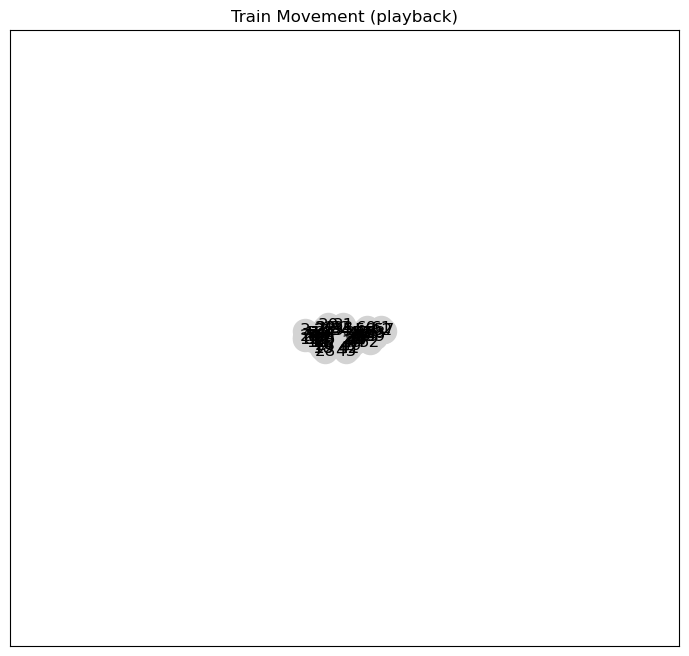

In [24]:
import csv
import math
import random
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from datetime import datetime, timedelta

# =========================
# Config (edit if needed)
# =========================
CSV_FILE = 'Book-(Sheet1).csv'
START_TIME = datetime(2025, 8, 12, 12, 0, 0)

SECTION_HEADWAY = 2.0
SWITCH_HEADWAY = 5.0
PLATFORM_HEADWAY = 1.0

DWELL_STOP = 5.0
DWELL_PASS = 0.0

MIN_TRAVEL_TIME = 0.01   # minutes
SPEED_KM_H = 40.0

ALL_TO_ALL_MODE = "sample"
MAX_TRAINS = 40
INJECTION_GAP_MIN = 1.0

FRAMES_PER_MIN = 10
SIM_DURATION_MIN = 120
FRAME_INTERVAL_MS = 70

DEBUG = True
RANDOM_SEED = 42
random.seed(RANDOM_SEED)

# =========================
# Load graph from CSV
# =========================
G = nx.Graph()
with open(CSV_FILE, newline='', encoding='utf-8') as f:
    reader = csv.DictReader(f)
    node_col = 'nodes'
    x_col = 'x'
    y_col = 'y'
    adj_col = 'adjacent_connected_node(s)'
    for row in reader:
        node = str(row[node_col]).strip()
        x = float(row[x_col])
        y = float(row[y_col])
        G.add_node(node, x=x, y=y)
        raw_adj = str(row.get(adj_col, "")).strip()
        if raw_adj and raw_adj.lower() != 'nan':
            raw_adj = raw_adj.replace('"','').replace("'", "")
            sep = ',' if ',' in raw_adj else ';' if ';' in raw_adj else ' '
            for tok in [t.strip() for t in raw_adj.split(sep) if t.strip()]:
                # if adjacent node missing coords yet, add placeholder (coords will be missing)
                if tok not in G:
                    G.add_node(tok) 
                # safe compute length: if either node missing coords, use 1.0
                if 'x' in G.nodes[tok] and 'x' in G.nodes[node]:
                    dist = math.hypot(G.nodes[node]['x'] - G.nodes[tok]['x'],
                                      G.nodes[node]['y'] - G.nodes[tok]['y'])
                else:
                    dist = 1.0
                G.add_edge(node, tok, length=dist)

if DEBUG:
    print(f"Loaded graph with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")

# =========================
# Travel-time helpers
# =========================
def euclidean_m(u, v):
    xu, yu = G.nodes[u]['x'], G.nodes[u]['y']
    xv, yv = G.nodes[v]['x'], G.nodes[v]['y']
    return math.hypot(xv - xu, yv - yu)

def travel_minutes_from_coords(u, v):
    speed_m_per_min = (SPEED_KM_H * 1000.0) / 60.0
    d_m = euclidean_m(u, v)
    t_min = d_m / speed_m_per_min
    if t_min < MIN_TRAVEL_TIME and DEBUG:
        print(f"🚧 Debug: Edge {u}->{v} very small travel_time = {t_min:.6f} min -> forcing minimum {MIN_TRAVEL_TIME:.6f} min")
    return max(t_min, MIN_TRAVEL_TIME)

def is_switch(node):
    return G.degree(node) >= 3

# =========================
# Build OD pairs
# =========================
nodes = list(G.nodes)
if ALL_TO_ALL_MODE == "all":
    pairs = [(s,d) for s in nodes for d in nodes if s!=d]
    if len(pairs) > MAX_TRAINS:
        pairs = pairs[:MAX_TRAINS]
elif ALL_TO_ALL_MODE == "sample":
    full_pairs = [(s,d) for s in nodes for d in nodes if s!=d]
    pairs = full_pairs if len(full_pairs) <= MAX_TRAINS else random.sample(full_pairs, MAX_TRAINS)
else:
    pairs = [("2","58"), ("3","58"), ("59","1")]  # example

if DEBUG:
    print(f"Generated {len(pairs)} OD pairs")

# =========================
# Train class + scheduler
# =========================
class Train:
    def __init__(self, tid, route, start_dt, is_stopping=True):
        self.tid = tid
        self.route = route[:]
        self.start_dt = start_dt
        self.is_stopping = is_stopping
        self.path_log = []
        self.sections_used = []

def schedule_trains(pairs, injection_gap_min=INJECTION_GAP_MIN):
    trains = []
    section_free = {}
    switch_free = {}
    platform_free = {}

    next_injection_time = START_TIME
    tid = 0
    for s,d in pairs:
        try:
            route = nx.shortest_path(G, s, d)
        except Exception:
            if DEBUG:
                print(f"⚠ No path {s}->{d}, skipping")
            continue
        tid += 1
        train = Train(tid, route, next_injection_time, is_stopping=(random.random()<0.7))
        time_cursor = next_injection_time

        for i, node in enumerate(route):
            x = float(G.nodes[node]['x'])
            y = float(G.nodes[node]['y'])
            arrival = time_cursor
            dwell = DWELL_STOP if train.is_stopping else DWELL_PASS
            departure = arrival + timedelta(seconds=dwell*60)

            # platform headway
            pf = platform_free.get(node, START_TIME)
            if arrival < pf:
                arrival = pf
                departure = arrival + timedelta(seconds=dwell*60)
            platform_free[node] = departure + timedelta(seconds=PLATFORM_HEADWAY*60)

            train.path_log.append({'node':node,'arrival':arrival,'departure':departure,'x':x,'y':y,'stopping':train.is_stopping})

            if i < len(route)-1:
                u,v = node, route[i+1]
                travel_min = travel_minutes_from_coords(u, v)

                section_key = frozenset({u,v})
                sec_free = section_free.get(section_key, START_TIME)
                if departure < sec_free:
                    departure = sec_free
                    platform_free[node] = departure + timedelta(seconds=PLATFORM_HEADWAY*60)
                    train.path_log[-1]['departure'] = departure

                if is_switch(u):
                    sw_free = switch_free.get(u, START_TIME)
                    if departure < sw_free:
                        departure = sw_free
                        platform_free[node] = departure + timedelta(seconds=PLATFORM_HEADWAY*60)
                        train.path_log[-1]['departure'] = departure
                if is_switch(v):
                    sw_free = switch_free.get(v, START_TIME)
                    if departure < sw_free:
                        departure = sw_free
                        platform_free[node] = departure + timedelta(seconds=PLATFORM_HEADWAY*60)
                        train.path_log[-1]['departure'] = departure

                start_move = departure
                arrival_next = start_move + timedelta(seconds=travel_min*60)

                train.sections_used.append((u,v,start_move,arrival_next))

                section_free[section_key] = arrival_next + timedelta(seconds=SECTION_HEADWAY*60)
                if is_switch(u): switch_free[u] = arrival_next + timedelta(seconds=SWITCH_HEADWAY*60)
                if is_switch(v): switch_free[v] = arrival_next + timedelta(seconds=SWITCH_HEADWAY*60)

                time_cursor = arrival_next
            else:
                time_cursor = departure

        trains.append(train)
        next_injection_time = next_injection_time + timedelta(seconds=injection_gap_min*60)

    return trains

trains = schedule_trains(pairs)
print(f"Scheduled {len(trains)} trains")

# =========================
# Conflict detection
# =========================
conflicts = []
for i in range(len(trains)):
    for j in range(i+1, len(trains)):
        t1, t2 = trains[i], trains[j]
        for s1 in t1.sections_used:
            for s2 in t2.sections_used:
                if frozenset({s1[0], s1[1]}) == frozenset({s2[0], s2[1]}):
                    latest_start = max(s1[2], s2[2])
                    earliest_end = min(s1[3], s2[3])
                    if latest_start < earliest_end:
                        conflicts.append((t1.tid, t2.tid, (s1[0], s1[1]), latest_start, earliest_end))
if conflicts:
    print("⚠ Conflicts detected:")
    for c in conflicts:
        print(f" Train {c[0]} & {c[1]} overlap on {c[2]} between {c[3]} and {c[4]}")
else:
    print("✅ No section overlap conflicts detected")

# =========================
# Animation (safe update)
# =========================
xs_all = [G.nodes[n]['x'] for n in G.nodes]
ys_all = [G.nodes[n]['y'] for n in G.nodes]

fig, ax = plt.subplots(figsize=(12,8))
ax.set_xlim(min(xs_all)-100, max(xs_all)+100)
ax.set_ylim(min(ys_all)-100, max(ys_all)+100)
ax.set_aspect('equal')

pos = {n:(G.nodes[n]['x'], G.nodes[n]['y']) for n in G.nodes}
nx.draw_networkx(G, pos=pos, ax=ax, node_color='lightgray', edge_color='gray', with_labels=True)

cmap = mpl.colormaps.get_cmap('tab20')
train_scat = ax.scatter([], [], s=100, zorder=5)
train_texts = [ax.text(0,0,"", fontsize=9, zorder=6) for _ in trains]

TOTAL_FRAMES = FRAMES_PER_MIN * SIM_DURATION_MIN

def update(frame):
    current_time = START_TIME + timedelta(minutes=(frame / FRAMES_PER_MIN))
    pts = []
    cols = []
    # reset all labels to empty by default
    for ttext in train_texts:
        ttext.set_text("")

    for idx, train in enumerate(trains):
        if not train.path_log:
            continue
        first_arr = train.path_log[0]['arrival']
        last_dep = train.path_log[-1]['departure']

        if current_time < first_arr:
            # not injected yet
            continue
        if current_time >= last_dep:
            # finished -> place at last node
            step = train.path_log[-1]
            pts.append((step['x'], step['y']))
            cols.append(cmap(idx % 20))
            train_texts[idx].set_position((step['x']+5, step['y']+5))
            train_texts[idx].set_text(f"T{train.tid}")
            continue

        # find segment where train is
        plotted = False
        for k in range(len(train.path_log)-1):
            n1 = train.path_log[k]
            n2 = train.path_log[k+1]
            # stopped at n1
            if n1['arrival'] <= current_time <= n1['departure']:
                pts.append((n1['x'], n1['y']))
                cols.append(cmap(idx % 20))
                train_texts[idx].set_position((n1['x']+5, n1['y']+5))
                train_texts[idx].set_text(f"T{train.tid}")
                plotted = True
                break
            # moving between n1.departure and n2.arrival
            if n1['departure'] <= current_time <= n2['arrival']:
                dt = (n2['arrival'] - n1['departure']).total_seconds()
                if dt <= 0:
                    prog = 1.0
                else:
                    prog = (current_time - n1['departure']).total_seconds() / dt
                prog = min(max(prog, 0.0), 1.0)
                x = n1['x'] + (n2['x'] - n1['x']) * prog
                y = n1['y'] + (n2['y'] - n1['y']) * prog
                pts.append((x,y))
                cols.append(cmap(idx % 20))
                train_texts[idx].set_position((x+5, y+5))
                train_texts[idx].set_text(f"T{train.tid}")
                plotted = True
                break
        if not plotted:
            # fallback to last node
            step = train.path_log[-1]
            pts.append((step['x'], step['y']))
            cols.append(cmap(idx % 20))
            train_texts[idx].set_position((step['x']+5, step['y']+5))
            train_texts[idx].set_text(f"T{train.tid}")

    # Ensure offsets array is 2D; if empty provide shape (0,2)
    if len(pts) == 0:
        train_scat.set_offsets(np.empty((0,2)))
        train_scat.set_color([])
    else:
        train_scat.set_offsets(pts)
        train_scat.set_color(cols)

    ax.set_title(f"Playback @ {current_time.strftime('%H:%M:%S')}")
    return (train_scat, *train_texts)

ani = mpl.animation.FuncAnimation(fig, update, frames=TOTAL_FRAMES, interval=FRAME_INTERVAL_MS, blit=False, repeat=False)

plt.title("Train Movement (playback)")
plt.show()


Loaded 62 nodes and 73 edges.
Generating 40 trips (mode=sample).
Scheduled 40 trains.
✅ No section overlap conflicts detected.

--- Train logs (summary) ---
Train 1 (stops=no): route ['43', '42', '41', '40', '39', '44', '52', '53', '59']
  Node 43: Arr=12:00:00, Dep=12:00:00
  Node 42: Arr=12:01:07, Dep=12:06:07
  Node 41: Arr=12:07:15, Dep=12:07:15
  Node 40: Arr=12:08:23, Dep=12:13:23
  Node 39: Arr=12:14:31, Dep=12:19:31
  Node 44: Arr=12:20:45, Dep=12:25:45
  Node 52: Arr=12:27:47, Dep=12:27:47
  Node 53: Arr=12:28:55, Dep=12:33:55
  Node 59: Arr=12:35:27, Dep=12:35:27
  Sections used:
    43->42: 12:00:00 -> 12:01:07
    42->41: 12:06:07 -> 12:07:15
    41->40: 12:07:15 -> 12:08:23
    40->39: 12:13:23 -> 12:14:31
    39->44: 12:19:31 -> 12:20:45
    44->52: 12:25:45 -> 12:27:47
    52->53: 12:27:47 -> 12:28:55
    53->59: 12:33:55 -> 12:35:27

Train 2 (stops=yes): route ['8', '5', '14', '16', '21', '22', '29', '30', '31']
  Node 8: Arr=12:01:00, Dep=12:06:00
  Node 5: Arr=12:07:0

c:\Users\Admin\anaconda3\Lib\site-packages\matplotlib\animation.py:872: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you output the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


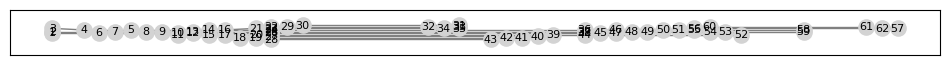

In [25]:
# train_sim_physics_viz.py
import csv
import math
import random
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from datetime import datetime, timedelta

# ----------------------------
# USER PARAMETERS (edit if needed)
# ----------------------------
CSV_FILE = 'Book-(Sheet1).csv'
START_TIME = datetime(2025, 8, 12, 12, 0, 0)

# coordinate scales (from your statement):
# x units in CSV: 1 unit = 1 cm in plot coordinates => 1 cm on x = 100 m real
# y units in CSV: 1 unit = 1 cm in plot coordinates => 1 cm on y = 5 m real
X_SCALE_M_PER_UNIT = 100.0   # multiply CSV x by this to get meters
Y_SCALE_M_PER_UNIT = 5.0     # multiply CSV y by this to get meters

# train / motion parameters
V_MAX_KMPH = 30.0                    # 30 km/h
V_MAX_MPS = (V_MAX_KMPH * 1000.0) / 3600.0  # m/s
ACCELERATION = 0.6    # m/s^2 (used previously)
TRAIN_LENGTH_M = 400.0  # meters

# headways (minutes)
HEADWAY_SECTION_MIN = 2.0
HEADWAY_SWITCH_MIN = 5.0
HEADWAY_PLATFORM_MIN = 1.0

# dwell times (minutes)
DWELL_STOP_MIN = 5.0
DWELL_PASS_MIN = 0.0

# minimal travel time safeguard (minutes)
MIN_TRAVEL_TIME_MIN = 0.01

# scheduling / OD generation
ALL_TO_ALL_MODE = "sample"   # "all" or "sample" or "pairs_list"
MAX_TRAINS = 40
INJECTION_GAP_MIN = 1.0

# animation
FRAMES_PER_MIN = 10
SIM_DURATION_MIN = 120
FRAME_INTERVAL_MS = 70

DEBUG = True
RANDOM_SEED = 42
random.seed(RANDOM_SEED)

# ----------------------------
# LOAD CSV and build graph
# ----------------------------
G = nx.Graph()
with open(CSV_FILE, newline='', encoding='utf-8') as f:
    reader = csv.DictReader(f)
    node_col = 'nodes'
    x_col = 'x'
    y_col = 'y'
    adj_col = 'adjacent_connected_node(s)'
    rows = list(reader)

# Add nodes with scaled meter coordinates
for row in rows:
    node = str(row[node_col]).strip()
    x_unit = float(row[x_col])
    y_unit = float(row[y_col])
    # convert to meters using provided scales
    xm = x_unit * X_SCALE_M_PER_UNIT
    ym = y_unit * Y_SCALE_M_PER_UNIT
    G.add_node(node, xm=xm, ym=ym)

# Add edges from adjacency lists; edge 'length_m' stored
for row in rows:
    node = str(row[node_col]).strip()
    raw_adj = str(row.get(adj_col, "")).strip()
    if raw_adj and raw_adj.lower() != 'nan':
        raw_adj = raw_adj.replace('"', '').replace("'", "")
        sep = ',' if ',' in raw_adj else ';' if ';' in raw_adj else ' '
        for tok in [t.strip() for t in raw_adj.split(sep) if t.strip()]:
            if tok not in G:
                # if adjacent mentioned but not present as row, create placeholder
                G.add_node(tok, xm=0.0, ym=0.0)
            # compute Euclidean distance in meters
            xu, yu = G.nodes[node]['xm'], G.nodes[node]['ym']
            xv, yv = G.nodes[tok]['xm'], G.nodes[tok]['ym']
            length_m = math.hypot(xv - xu, yv - yu)
            # add undirected edge
            if not G.has_edge(node, tok):
                G.add_edge(node, tok, length_m=length_m)

if DEBUG:
    print(f"Loaded {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")

# ----------------------------
# PHYSICS: compute traversal time for a given distance (meters)
# returns time in seconds (float)
# Consider acceleration to v_max, cruise, deceleration.
# For occupancy we use distance_to_travel = d + TRAIN_LENGTH_M (front leaves start node until tail clears end node)
# ----------------------------
def travel_time_seconds_for_distance(distance_m, v_max_mps=V_MAX_MPS, accel=ACCELERATION):
    # distance_m: meters that front must travel relative to initial front position to tail clear final node
    # compute trapezoidal or triangular profile
    t_acc = v_max_mps / accel
    d_acc = 0.5 * accel * t_acc * t_acc
    d_dec = d_acc
    if d_acc + d_dec < distance_m:
        d_cruise = distance_m - (d_acc + d_dec)
        t_cruise = d_cruise / v_max_mps
        t_total = t_acc + t_cruise + t_acc
    else:
        # triangular (don't reach v_max)
        # t_total = 2 * sqrt(distance / accel)
        t_total = 2.0 * math.sqrt(max(distance_m, 0.0) / accel)
    # minimal safeguard
    return max(t_total, MIN_TRAVEL_TIME_MIN * 60.0)

# Wrapper: travel minutes for a section between node u and v, accounting train length
def section_travel_time_minutes(u, v):
    # center-to-center node distance
    xu, yu = G.nodes[u]['xm'], G.nodes[u]['ym']
    xv, yv = G.nodes[v]['xm'], G.nodes[v]['ym']
    d = math.hypot(xv - xu, yv - yu)  # meters
    # distance that front must travel so tail clears next node center: d + TRAIN_LENGTH_M
    effective_distance = max(d + TRAIN_LENGTH_M, TRAIN_LENGTH_M)
    secs = travel_time_seconds_for_distance(effective_distance)
    mins = secs / 60.0
    if mins < MIN_TRAVEL_TIME_MIN and DEBUG:
        print(f"🚧 Debug: computed tiny travel time {mins:.6f} min for edge {u}->{v}, forcing minimum {MIN_TRAVEL_TIME_MIN}")
    return max(mins, MIN_TRAVEL_TIME_MIN)

# ----------------------------
# build OD pairs
# ----------------------------
nodes = list(G.nodes)
pairs = []
if ALL_TO_ALL_MODE == "all":
    pairs = [(s, d) for s in nodes for d in nodes if s != d]
    if len(pairs) > MAX_TRAINS:
        pairs = pairs[:MAX_TRAINS]
elif ALL_TO_ALL_MODE == "sample":
    full_pairs = [(s, d) for s in nodes for d in nodes if s != d]
    pairs = full_pairs if len(full_pairs) <= MAX_TRAINS else random.sample(full_pairs, MAX_TRAINS)
else:
    # example list (replace with your specific pairs if desired)
    pairs = [("2", "58"), ("3", "58"), ("59", "1")]

if DEBUG:
    print(f"Generating {len(pairs)} trips (mode={ALL_TO_ALL_MODE}).")

# ----------------------------
# Train class and scheduler
# ----------------------------
class Train:
    def __init__(self, tid, route, start_dt, is_stopping=True):
        self.tid = tid
        self.route = route[:]
        self.start_dt = start_dt
        self.is_stopping = is_stopping
        self.path_log = []      # each entry: {'node','arrival'(dt),'departure'(dt),'xm','ym','stopping'}
        self.sections_used = [] # list of (u,v,start_dt,end_dt)

def schedule_trains(pairs, injection_gap_min=INJECTION_GAP_MIN):
    trains = []
    section_free = {}   # frozenset({u,v}) -> datetime when free
    switch_free = {}    # node -> datetime
    platform_free = {}  # node -> datetime

    next_injection_time = START_TIME
    tid = 0
    for (s, d) in pairs:
        # try to get a path
        try:
            route = nx.shortest_path(G, s, d)
        except nx.NetworkXNoPath:
            if DEBUG:
                print(f"⚠ No path {s}->{d} — skipping")
            continue

        tid += 1
        train = Train(tid, route, start_dt=next_injection_time, is_stopping=(random.random() < 0.7))
        time_cursor = next_injection_time

        for i, node in enumerate(route):
            xm, ym = G.nodes[node]['xm'], G.nodes[node]['ym']
            arrival = time_cursor
            dwell_min = DWELL_STOP_MIN if train.is_stopping else DWELL_PASS_MIN
            departure = arrival + timedelta(seconds=dwell_min * 60.0)

            # platform headway: can't occupy platform until free
            pf = platform_free.get(node, START_TIME)
            if arrival < pf:
                arrival = pf
                departure = arrival + timedelta(seconds=dwell_min * 60.0)

            # update platform_free (node blocked until departure + platform headway)
            platform_free[node] = departure + timedelta(seconds=HEADWAY_PLATFORM_MIN * 60.0)

            # log node occupancy
            train.path_log.append({
                'node': node,
                'arrival': arrival,
                'departure': departure,
                'xm': xm,
                'ym': ym,
                'stopping': train.is_stopping
            })

            # if next node exists, compute travel+section occupancy
            if i < len(route) - 1:
                u, v = node, route[i+1]
                # travel minutes for section (includes train length)
                travel_min = section_travel_time_minutes(u, v)

                # next departure must respect section and switch frees
                section_key = frozenset({u, v})
                sec_free_dt = section_free.get(section_key, START_TIME)
                if departure < sec_free_dt:
                    departure = sec_free_dt
                    # update platform_free and log
                    platform_free[node] = departure + timedelta(seconds=HEADWAY_PLATFORM_MIN * 60.0)
                    train.path_log[-1]['departure'] = departure

                # switch constraints (node u and v if they are switches)
                if G.degree(u) >= 3:
                    swf = switch_free.get(u, START_TIME)
                    if departure < swf:
                        departure = swf
                        platform_free[node] = departure + timedelta(seconds=HEADWAY_PLATFORM_MIN * 60.0)
                        train.path_log[-1]['departure'] = departure
                if G.degree(v) >= 3:
                    swf = switch_free.get(v, START_TIME)
                    if departure < swf:
                        departure = swf
                        platform_free[node] = departure + timedelta(seconds=HEADWAY_PLATFORM_MIN * 60.0)
                        train.path_log[-1]['departure'] = departure

                # movement begins at 'departure' (front leaves node center)
                start_move = departure
                arrival_next = start_move + timedelta(seconds=travel_min * 60.0)

                # section is occupied from start_move until arrival_next (tail cleared)
                train.sections_used.append((u, v, start_move, arrival_next))

                # update frees
                section_free[section_key] = arrival_next + timedelta(seconds=HEADWAY_SECTION_MIN * 60.0)
                if G.degree(u) >= 3:
                    switch_free[u] = arrival_next + timedelta(seconds=HEADWAY_SWITCH_MIN * 60.0)
                if G.degree(v) >= 3:
                    switch_free[v] = arrival_next + timedelta(seconds=HEADWAY_SWITCH_MIN * 60.0)

                # move cursor to the arrival_next for next node's arrival
                time_cursor = arrival_next
            else:
                # last node
                time_cursor = departure

        trains.append(train)
        # stagger next injection
        next_injection_time = next_injection_time + timedelta(seconds=injection_gap_min * 60.0)

    return trains

# schedule
trains = schedule_trains(pairs, injection_gap_min=INJECTION_GAP_MIN)
print(f"Scheduled {len(trains)} trains.")

# ----------------------------
# Conflict check (just in case)
# ----------------------------
conflicts = []
for i in range(len(trains)):
    for j in range(i+1, len(trains)):
        t1, t2 = trains[i], trains[j]
        for s1 in t1.sections_used:
            for s2 in t2.sections_used:
                if frozenset({s1[0], s1[1]}) == frozenset({s2[0], s2[1]}):
                    latest_start = max(s1[2], s2[2])
                    earliest_end = min(s1[3], s2[3])
                    if latest_start < earliest_end:
                        conflicts.append((t1.tid, t2.tid, (s1[0], s1[1]), latest_start, earliest_end))
if conflicts:
    print("⚠ Conflicts detected:")
    for c in conflicts:
        print(f" Train {c[0]} & {c[1]} overlap on {c[2]} between {c[3]} and {c[4]}")
else:
    print("✅ No section overlap conflicts detected.")

# ----------------------------
# Print train logs summary (brief)
# ----------------------------
print("\n--- Train logs (summary) ---")
for train in trains[:min(10, len(trains))]:
    print(f"Train {train.tid} (stops={'yes' if train.is_stopping else 'no'}): route {train.route}")
    for step in train.path_log:
        print(f"  Node {step['node']}: Arr={step['arrival'].strftime('%H:%M:%S')}, Dep={step['departure'].strftime('%H:%M:%S')}")
    print("  Sections used:")
    for sec in train.sections_used:
        print(f"    {sec[0]}->{sec[1]}: {sec[2].strftime('%H:%M:%S')} -> {sec[3].strftime('%H:%M:%S')}")
    print()

# ----------------------------
# Save movement log (tabular) for later analysis (optional)
# ----------------------------
# Build a master list of all node visits
movement_log = []
for train in trains:
    for step in train.path_log:
        movement_log.append({
            'train_id': train.tid,
            'node': step['node'],
            'arrival': step['arrival'],
            'departure': step['departure'],
            'xm': step['xm'],
            'ym': step['ym'],
            'stopping': step['stopping']
        })

# (optionally) write movement_log to CSV for analysis
# import pandas as pd
# pd.DataFrame(movement_log).to_csv('/mnt/data/movement_log.csv', index=False)

# ----------------------------
# ANIMATION (fixed axes, clearer visuals)
# ----------------------------
# compute plot bounds and add margin
xs = [G.nodes[n]['xm'] for n in G.nodes]
ys = [G.nodes[n]['ym'] for n in G.nodes]
xmin, xmax = min(xs), max(xs)
ymin, ymax = min(ys), max(ys)
xpad = max(50.0, 0.05 * (xmax - xmin + 1.0))
ypad = max(50.0, 0.05 * (ymax - ymin + 1.0))

fig, ax = plt.subplots(figsize=(12, 9))
ax.set_xlim(xmin - xpad, xmax + xpad)
ax.set_ylim(ymin - ypad, ymax + ypad)
ax.set_aspect('equal')

pos = {n: (G.nodes[n]['xm'], G.nodes[n]['ym']) for n in G.nodes}
nx.draw_networkx_nodes(G, pos=pos, ax=ax, node_color='lightgray', node_size=120)
nx.draw_networkx_edges(G, pos=pos, ax=ax, edge_color='gray')
nx.draw_networkx_labels(G, pos=pos, ax=ax, font_size=8)

cmap = mpl.colormaps.get_cmap('tab20')
train_scat = ax.scatter([], [], s=80, zorder=6)
train_texts = [ax.text(0,0,"", fontsize=8, zorder=7) for _ in trains]

TOTAL_FRAMES = FRAMES_PER_MIN * SIM_DURATION_MIN

def update(frame):
    current_time = START_TIME + timedelta(minutes=(frame / FRAMES_PER_MIN))
    pts = []
    cols = []
    # clear labels
    for tt in train_texts:
        tt.set_text("")

    for idx, train in enumerate(trains):
        if not train.path_log:
            continue
        # if not yet injected
        first_arr = train.path_log[0]['arrival']
        last_dep = train.path_log[-1]['departure']
        if current_time < first_arr:
            continue
        if current_time >= last_dep:
            step = train.path_log[-1]
            pts.append((step['xm'], step['ym']))
            cols.append(cmap(idx % 20))
            train_texts[idx].set_position((step['xm'] + 5, step['ym'] + 5))
            train_texts[idx].set_text(f"T{train.tid}")
            continue

        # find where train is
        plotted = False
        for k in range(len(train.path_log) - 1):
            n1 = train.path_log[k]
            n2 = train.path_log[k+1]
            if n1['arrival'] <= current_time <= n1['departure']:
                pts.append((n1['xm'], n1['ym']))
                cols.append(cmap(idx % 20))
                train_texts[idx].set_position((n1['xm'] + 5, n1['ym'] + 5))
                train_texts[idx].set_text(f"T{train.tid}")
                plotted = True
                break
            if n1['departure'] <= current_time <= n2['arrival']:
                dt = (n2['arrival'] - n1['departure']).total_seconds()
                if dt <= 0:
                    prog = 1.0
                else:
                    prog = (current_time - n1['departure']).total_seconds() / dt
                prog = min(max(prog, 0.0), 1.0)
                x = n1['xm'] + (n2['xm'] - n1['xm']) * prog
                y = n1['ym'] + (n2['ym'] - n1['ym']) * prog
                pts.append((x, y))
                cols.append(cmap(idx % 20))
                train_texts[idx].set_position((x + 5, y + 5))
                train_texts[idx].set_text(f"T{train.tid}")
                plotted = True
                break
        if not plotted:
            step = train.path_log[-1]
            pts.append((step['xm'], step['ym']))
            cols.append(cmap(idx % 20))
            train_texts[idx].set_position((step['xm'] + 5, step['ym'] + 5))
            train_texts[idx].set_text(f"T{train.tid}")

    if len(pts) == 0:
        train_scat.set_offsets(np.empty((0,2)))
        train_scat.set_color([])
    else:
        train_scat.set_offsets(pts)
        train_scat.set_color(cols)

    ax.set_title(f"Train movement playback @ {current_time.strftime('%H:%M:%S')}")
    return (train_scat, *train_texts)

ani = mpl.animation.FuncAnimation(fig, update, frames=TOTAL_FRAMES, interval=FRAME_INTERVAL_MS, blit=False, repeat=False)
plt.show()


Loaded 62 nodes and 73 edges (using your original coordinates for plotting).
Scheduling 40 trips (mode=sample)
Scheduled 40 trains.
✅ No section overlap conflicts detected.


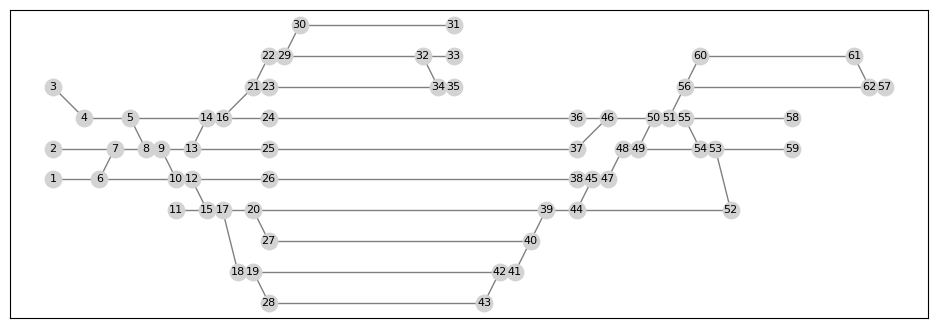

In [27]:
import csv
import math
import random
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from datetime import datetime, timedelta

# ----------------------------
# USER PARAMETERS
# ----------------------------
CSV_FILE = 'Book-(Sheet1).csv'
START_TIME = datetime(2025, 8, 12, 12, 0, 0)

# coordinate scales (your statement)
X_SCALE_M_PER_UNIT = 100.0   # CSV x unit -> meters
Y_SCALE_M_PER_UNIT = 5.0     # CSV y unit -> meters

# train / motion parameters
V_MAX_KMPH = 30.0
V_MAX_MPS = (V_MAX_KMPH * 1000.0) / 3600.0
ACCELERATION = 0.6    # m/s^2
TRAIN_LENGTH_M = 400.0

# headways / dwell (minutes)
HEADWAY_SECTION_MIN = 2.0
HEADWAY_SWITCH_MIN = 5.0
HEADWAY_PLATFORM_MIN = 1.0
DWELL_STOP_MIN = 5.0
DWELL_PASS_MIN = 0.0

MIN_TRAVEL_TIME_MIN = 0.01

# OD generation / scheduling
ALL_TO_ALL_MODE = "sample"
MAX_TRAINS = 40
INJECTION_GAP_MIN = 1.0

# animation
FRAMES_PER_MIN = 10
SIM_DURATION_MIN = 120
FRAME_INTERVAL_MS = 70

DEBUG = True
RANDOM_SEED = 42
random.seed(RANDOM_SEED)

# ----------------------------
# LOAD CSV & BUILD GRAPH
# ----------------------------
G = nx.Graph()
rows = []
with open(CSV_FILE, newline='', encoding='utf-8') as f:
    reader = csv.DictReader(f)
    rows = list(reader)
    if not rows:
        raise RuntimeError("CSV empty or unreadable")

# add nodes storing original units and meter-converted coords
for row in rows:
    node = str(row['nodes']).strip()
    x_unit = float(row['x'])
    y_unit = float(row['y'])
    xm = x_unit * X_SCALE_M_PER_UNIT
    ym = y_unit * Y_SCALE_M_PER_UNIT
    G.add_node(node, x_unit=x_unit, y_unit=y_unit, xm=xm, ym=ym)

# add edges from adjacency; compute length in meters using xm,ym
for row in rows:
    node = str(row['nodes']).strip()
    raw_adj = str(row.get('adjacent_connected_node(s)', "")).strip()
    if raw_adj and raw_adj.lower() != 'nan':
        raw_adj = raw_adj.replace('"', '').replace("'", "")
        sep = ',' if ',' in raw_adj else ';' if ';' in raw_adj else ' '
        for tok in [t.strip() for t in raw_adj.split(sep) if t.strip()]:
            if tok not in G:
                # create placeholder if referenced but not present
                G.add_node(tok, x_unit=0.0, y_unit=0.0, xm=0.0, ym=0.0)
            xu, yu = G.nodes[node]['xm'], G.nodes[node]['ym']
            xv, yv = G.nodes[tok]['xm'], G.nodes[tok]['ym']
            length_m = math.hypot(xv - xu, yv - yu)
            if not G.has_edge(node, tok):
                G.add_edge(node, tok, length_m=length_m)

if DEBUG:
    print(f"Loaded {G.number_of_nodes()} nodes and {G.number_of_edges()} edges (using your original coordinates for plotting).")

# ----------------------------
# Physics helpers (meters)
# ----------------------------
def travel_time_seconds_for_distance(distance_m, v_max_mps=V_MAX_MPS, accel=ACCELERATION):
    t_acc = v_max_mps / accel
    d_acc = 0.5 * accel * t_acc**2
    d_dec = d_acc
    if d_acc + d_dec < distance_m:
        d_cruise = distance_m - (d_acc + d_dec)
        t_cruise = d_cruise / v_max_mps
        t_total = t_acc + t_cruise + t_acc
    else:
        t_total = 2.0 * math.sqrt(max(distance_m, 0.0) / accel)
    return max(t_total, MIN_TRAVEL_TIME_MIN * 60.0)

def section_travel_time_minutes(u, v):
    xu, yu = G.nodes[u]['xm'], G.nodes[u]['ym']
    xv, yv = G.nodes[v]['xm'], G.nodes[v]['ym']
    d = math.hypot(xv - xu, yv - yu)  # center-to-center metres
    effective_distance = max(d + TRAIN_LENGTH_M, TRAIN_LENGTH_M)
    secs = travel_time_seconds_for_distance(effective_distance)
    mins = secs / 60.0
    if mins < MIN_TRAVEL_TIME_MIN and DEBUG:
        print(f"🚧 Debug: tiny travel time {mins:.6f} min for {u}->{v}, using min {MIN_TRAVEL_TIME_MIN}")
    return max(mins, MIN_TRAVEL_TIME_MIN)

def is_switch(node):
    return G.degree(node) >= 3

# ----------------------------
# Build OD pairs (plotting uses x_unit/y_unit)
# ----------------------------
nodes = list(G.nodes)
if ALL_TO_ALL_MODE == "all":
    pairs = [(s,d) for s in nodes for d in nodes if s!=d][:MAX_TRAINS]
elif ALL_TO_ALL_MODE == "sample":
    full_pairs = [(s,d) for s in nodes for d in nodes if s!=d]
    pairs = full_pairs if len(full_pairs) <= MAX_TRAINS else random.sample(full_pairs, MAX_TRAINS)
else:
    pairs = [("2","58"), ("3","58"), ("59","1")]

if DEBUG:
    print(f"Scheduling {len(pairs)} trips (mode={ALL_TO_ALL_MODE})")

# ----------------------------
# Train & scheduling logic
# ----------------------------
class Train:
    def __init__(self, tid, route, start_dt, is_stopping=True):
        self.tid = tid
        self.route = route[:]
        self.start_dt = start_dt
        self.is_stopping = is_stopping
        self.path_log = []      # {'node','arrival','departure','x_unit','y_unit','xm','ym','stopping'}
        self.sections_used = []

def schedule_trains(pairs, injection_gap_min=INJECTION_GAP_MIN):
    trains = []
    section_free = {}
    switch_free = {}
    platform_free = {}
    next_injection_time = START_TIME
    tid = 0

    for s, d in pairs:
        try:
            route = nx.shortest_path(G, s, d)
        except nx.NetworkXNoPath:
            if DEBUG:
                print(f"⚠ No path {s}->{d} — skipping")
            continue

        tid += 1
        train = Train(tid, route, start_dt=next_injection_time, is_stopping=(random.random() < 0.7))
        time_cursor = next_injection_time

        for i, node in enumerate(route):
            x_unit = G.nodes[node]['x_unit']
            y_unit = G.nodes[node]['y_unit']
            xm = G.nodes[node]['xm']
            ym = G.nodes[node]['ym']

            arrival = time_cursor
            dwell_min = DWELL_STOP_MIN if train.is_stopping else DWELL_PASS_MIN
            departure = arrival + timedelta(seconds=dwell_min * 60.0)

            # platform headway
            pf = platform_free.get(node, START_TIME)
            if arrival < pf:
                arrival = pf
                departure = arrival + timedelta(seconds=dwell_min * 60.0)
            platform_free[node] = departure + timedelta(seconds=HEADWAY_PLATFORM_MIN * 60.0)

            train.path_log.append({
                'node': node, 'arrival': arrival, 'departure': departure,
                'x_unit': x_unit, 'y_unit': y_unit, 'xm': xm, 'ym': ym, 'stopping': train.is_stopping
            })

            if i < len(route) - 1:
                u, v = node, route[i+1]
                travel_min = section_travel_time_minutes(u, v)

                section_key = frozenset({u, v})
                sec_free_dt = section_free.get(section_key, START_TIME)
                if departure < sec_free_dt:
                    departure = sec_free_dt
                    platform_free[node] = departure + timedelta(seconds=HEADWAY_PLATFORM_MIN * 60.0)
                    train.path_log[-1]['departure'] = departure

                if is_switch(u):
                    swf = switch_free.get(u, START_TIME)
                    if departure < swf:
                        departure = swf
                        platform_free[node] = departure + timedelta(seconds=HEADWAY_PLATFORM_MIN * 60.0)
                        train.path_log[-1]['departure'] = departure
                if is_switch(v):
                    swf = switch_free.get(v, START_TIME)
                    if departure < swf:
                        departure = swf
                        platform_free[node] = departure + timedelta(seconds=HEADWAY_PLATFORM_MIN * 60.0)
                        train.path_log[-1]['departure'] = departure

                start_move = departure
                arrival_next = start_move + timedelta(seconds=travel_min * 60.0)

                train.sections_used.append((u, v, start_move, arrival_next))

                section_free[section_key] = arrival_next + timedelta(seconds=HEADWAY_SECTION_MIN * 60.0)
                if is_switch(u):
                    switch_free[u] = arrival_next + timedelta(seconds=HEADWAY_SWITCH_MIN * 60.0)
                if is_switch(v):
                    switch_free[v] = arrival_next + timedelta(seconds=HEADWAY_SWITCH_MIN * 60.0)

                time_cursor = arrival_next
            else:
                time_cursor = departure

        trains.append(train)
        next_injection_time = next_injection_time + timedelta(seconds=injection_gap_min * 60.0)

    return trains

trains = schedule_trains(pairs, injection_gap_min=INJECTION_GAP_MIN)
print(f"Scheduled {len(trains)} trains.")

# ----------------------------
# Conflict check (optional)
# ----------------------------
conflicts = []
for i in range(len(trains)):
    for j in range(i+1, len(trains)):
        for s1 in trains[i].sections_used:
            for s2 in trains[j].sections_used:
                if frozenset({s1[0], s1[1]}) == frozenset({s2[0], s2[1]}):
                    latest_start = max(s1[2], s2[2])
                    earliest_end = min(s1[3], s2[3])
                    if latest_start < earliest_end:
                        conflicts.append((trains[i].tid, trains[j].tid, (s1[0], s1[1]), latest_start, earliest_end))
if conflicts:
    print("⚠ Conflicts detected (section overlap):")
    for c in conflicts:
        print(f" Train {c[0]} & {c[1]} overlap on {c[2]} between {c[3]} and {c[4]}")
else:
    print("✅ No section overlap conflicts detected.")

# ----------------------------
# Animation: use original CSV coordinates (x_unit, y_unit) for plotting
# ----------------------------
x_units = [G.nodes[n]['x_unit'] for n in G.nodes]
y_units = [G.nodes[n]['y_unit'] for n in G.nodes]
xmin, xmax = min(x_units), max(x_units)
ymin, ymax = min(y_units), max(y_units)
xpad = max(0.5, 0.05 * (xmax - xmin + 1.0))
ypad = max(0.5, 0.05 * (ymax - ymin + 1.0))

fig, ax = plt.subplots(figsize=(14, 4))   # long wide figure often suits these railway layouts
ax.set_xlim(xmin - xpad, xmax + xpad)
ax.set_ylim(ymin - ypad, ymax + ypad)
ax.set_aspect('equal')  # keep units equal on both axes (so your coordinates are preserved)

# Draw nodes and edges using original units
pos_units = {n: (G.nodes[n]['x_unit'], G.nodes[n]['y_unit']) for n in G.nodes}
nx.draw_networkx_nodes(G, pos=pos_units, ax=ax, node_color='lightgray', node_size=140)
nx.draw_networkx_edges(G, pos=pos_units, ax=ax, edge_color='gray')
nx.draw_networkx_labels(G, pos=pos_units, ax=ax, font_size=8)

cmap = mpl.colormaps.get_cmap('tab20')
train_scat = ax.scatter([], [], s=80, zorder=6)
train_texts = [ax.text(0,0,"", fontsize=8, zorder=7) for _ in trains]

TOTAL_FRAMES = FRAMES_PER_MIN * SIM_DURATION_MIN

def update(frame):
    current_time = START_TIME + timedelta(minutes=(frame / FRAMES_PER_MIN))
    pts = []
    cols = []
    for tt in train_texts:
        tt.set_text("")

    for idx, train in enumerate(trains):
        if not train.path_log:
            continue
        first_arr = train.path_log[0]['arrival']
        last_dep = train.path_log[-1]['departure']
        if current_time < first_arr:
            continue
        if current_time >= last_dep:
            step = train.path_log[-1]
            pts.append((step['x_unit'], step['y_unit']))
            cols.append(cmap(idx % 20))
            train_texts[idx].set_position((step['x_unit'] + 0.4, step['y_unit'] + 0.2))
            train_texts[idx].set_text(f"T{train.tid}")
            continue

        plotted = False
        for k in range(len(train.path_log) - 1):
            n1 = train.path_log[k]
            n2 = train.path_log[k+1]
            if n1['arrival'] <= current_time <= n1['departure']:
                pts.append((n1['x_unit'], n1['y_unit']))
                cols.append(cmap(idx % 20))
                train_texts[idx].set_position((n1['x_unit'] + 0.4, n1['y_unit'] + 0.2))
                train_texts[idx].set_text(f"T{train.tid}")
                plotted = True
                break
            if n1['departure'] <= current_time <= n2['arrival']:
                dt = (n2['arrival'] - n1['departure']).total_seconds()
                if dt <= 0:
                    prog = 1.0
                else:
                    prog = (current_time - n1['departure']).total_seconds() / dt
                prog = min(max(prog, 0.0), 1.0)
                x = n1['x_unit'] + (n2['x_unit'] - n1['x_unit']) * prog
                y = n1['y_unit'] + (n2['y_unit'] - n1['y_unit']) * prog
                pts.append((x, y))
                cols.append(cmap(idx % 20))
                train_texts[idx].set_position((x + 0.4, y + 0.2))
                train_texts[idx].set_text(f"T{train.tid}")
                plotted = True
                break
        if not plotted:
            step = train.path_log[-1]
            pts.append((step['x_unit'], step['y_unit']))
            cols.append(cmap(idx % 20))
            train_texts[idx].set_position((step['x_unit'] + 0.4, step['y_unit'] + 0.2))
            train_texts[idx].set_text(f"T{train.tid}")

    if len(pts) == 0:
        train_scat.set_offsets(np.empty((0,2)))
        train_scat.set_color([])
    else:
        train_scat.set_offsets(pts)
        train_scat.set_color(cols)

    ax.set_title(f"Train movement playback @ {current_time.strftime('%H:%M:%S')}")
    return (train_scat, *train_texts)

ani = mpl.animation.FuncAnimation(fig, update, frames=TOTAL_FRAMES, interval=FRAME_INTERVAL_MS, blit=False, repeat=False)
plt.show()


Loaded graph: 62 nodes, 73 edges
Scheduling 40 OD trips
Scheduled 40 trains
Occupancy log saved to: out.csv  (records: 598)
Simulation covers 480.24 minutes from 2025-08-12 12:00:00 to 2025-08-12 20:00:14.445606


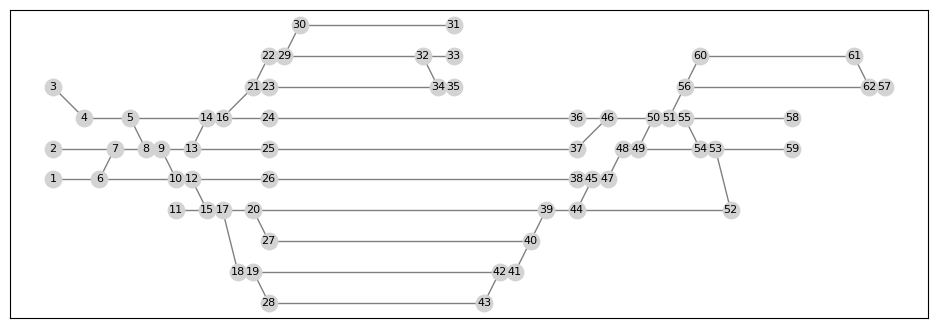

In [30]:
# integrated_occupancy_and_animation.py
import csv, math, random, networkx as nx, numpy as np, matplotlib.pyplot as plt, matplotlib as mpl
from datetime import datetime, timedelta

# ----------------------------
# USER PARAMETERS (edit if needed)
# ----------------------------
CSV_FILE = 'Book-(Sheet1).csv'
START_TIME = datetime(2025,8,12,12,0,0)

# coordinate scales
X_SCALE_M_PER_UNIT = 100.0   # csv x unit -> meters
Y_SCALE_M_PER_UNIT = 5.0     # csv y unit -> meters

# train physics
V_MAX_KMPH = 30.0
V_MAX_MPS = (V_MAX_KMPH * 1000.0) / 3600.0
ACCELERATION = 0.6   # m/s^2
TRAIN_LENGTH_M = 400.0

# headways/dwells (minutes)
HEADWAY_SECTION_MIN = 2.0
HEADWAY_SWITCH_MIN = 5.0
HEADWAY_PLATFORM_MIN = 1.0
DWELL_STOP_MIN = 5.0
DWELL_PASS_MIN = 0.0

MIN_TRAVEL_TIME_MIN = 0.01

# OD generation / scheduling
ALL_TO_ALL_MODE = "sample"   # "all", "sample", or "pairs_list"
MAX_TRAINS = 40
INJECTION_GAP_MIN = 1.0

# animation / playback
ANIM_DURATION_SECONDS = 60      # entire sim compressed to this many seconds
FPS = 20
FRAMES = int(ANIM_DURATION_SECONDS * FPS)
INTERVAL_MS = int(1000 / FPS)

# debug
DEBUG = True
RANDOM_SEED = 42
random.seed(RANDOM_SEED)

# ----------------------------
# load csv, build graph
# ----------------------------
G = nx.Graph()
rows = []
with open(CSV_FILE, newline='', encoding='utf-8') as f:
    reader = csv.DictReader(f)
    rows = list(reader)
    if not rows:
        raise RuntimeError("CSV appears empty")

for row in rows:
    node = str(row['nodes']).strip()
    x_unit = float(row['x'])
    y_unit = float(row['y'])
    xm = x_unit * X_SCALE_M_PER_UNIT
    ym = y_unit * Y_SCALE_M_PER_UNIT
    G.add_node(node, x_unit=x_unit, y_unit=y_unit, xm=xm, ym=ym)

for row in rows:
    node = str(row['nodes']).strip()
    raw_adj = str(row.get('adjacent_connected_node(s)', "")).strip()
    if raw_adj and raw_adj.lower() != 'nan':
        raw_adj = raw_adj.replace('"','').replace("'", "")
        sep = ',' if ',' in raw_adj else ';' if ';' in raw_adj else ' '
        for tok in [t.strip() for t in raw_adj.split(sep) if t.strip()]:
            if tok not in G:
                # placeholder if referenced but not in rows
                G.add_node(tok, x_unit=0.0, y_unit=0.0, xm=0.0, ym=0.0)
            xu, yu = G.nodes[node]['xm'], G.nodes[node]['ym']
            xv, yv = G.nodes[tok]['xm'], G.nodes[tok]['ym']
            length_m = math.hypot(xv - xu, yv - yu)
            if not G.has_edge(node, tok):
                G.add_edge(node, tok, length_m=length_m)

if DEBUG:
    print(f"Loaded graph: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")

# ----------------------------
# physics helpers (seconds)
# ----------------------------
def travel_time_seconds(distance_m, v_max=V_MAX_MPS, accel=ACCELERATION):
    # compute time for front to travel `distance_m` (m) with accel/cruise/decel
    t_acc = v_max / accel
    d_acc = 0.5 * accel * t_acc**2
    if d_acc * 2 < distance_m:
        d_cruise = distance_m - 2*d_acc
        t_cruise = d_cruise / v_max
        total = t_acc + t_cruise + t_acc
    else:
        # triangular
        total = 2.0 * math.sqrt(distance_m / accel)
    return max(total, MIN_TRAVEL_TIME_MIN * 60.0)

def section_times_seconds(u, v):
    # returns (t_center_sec, t_tail_sec)
    xu, yu = G.nodes[u]['xm'], G.nodes[u]['ym']
    xv, yv = G.nodes[v]['xm'], G.nodes[v]['ym']
    d = math.hypot(xv - xu, yv - yu)   # meters center-to-center
    t_center = travel_time_seconds(d)                    # front reaches next node center
    t_tail = travel_time_seconds(d + TRAIN_LENGTH_M)     # tail clears next node
    return t_center, t_tail

# ----------------------------
# build OD pairs
# ----------------------------
nodes = list(G.nodes)
if ALL_TO_ALL_MODE == "all":
    pairs = [(s,d) for s in nodes for d in nodes if s!=d][:MAX_TRAINS]
elif ALL_TO_ALL_MODE == "sample":
    full_pairs = [(s,d) for s in nodes for d in nodes if s!=d]
    pairs = full_pairs if len(full_pairs) <= MAX_TRAINS else random.sample(full_pairs, MAX_TRAINS)
else:
    pairs = [("2","58"), ("3","58"), ("59","1")]

if DEBUG:
    print(f"Scheduling {len(pairs)} OD trips")

# ----------------------------
# Train class and scheduler
# ----------------------------
class Train:
    def __init__(self, tid, route, start_dt, is_stopping=True):
        self.tid = tid
        self.route = route[:]
        self.start_dt = start_dt
        self.is_stopping = is_stopping
        self.path_log = []      # entries: node-level logs with front arrival/departure, and coordinates
        self.sections_used = [] # entries: (u,v,section_start_dt,section_end_dt_tail_clear)

def schedule_trains(pairs, injection_gap_min=INJECTION_GAP_MIN):
    trains = []
    section_free = {}
    switch_free = {}
    platform_free = {}
    next_injection = START_TIME
    tid = 0

    for s,d in pairs:
        try:
            route = nx.shortest_path(G, s, d)
        except nx.NetworkXNoPath:
            if DEBUG: print(f"No path {s}->{d}, skipping")
            continue
        tid += 1
        train = Train(tid, route, start_dt=next_injection, is_stopping=(random.random() < 0.7))
        time_cursor = next_injection

        for i, node in enumerate(route):
            # node front arrival is time_cursor
            xm = G.nodes[node]['xm']; ym = G.nodes[node]['ym']
            arrival_front = time_cursor
            dwell_min = DWELL_STOP_MIN if train.is_stopping else DWELL_PASS_MIN
            departure_front = arrival_front + timedelta(seconds=dwell_min * 60.0)

            # platform headway enforcement
            pf = platform_free.get(node, START_TIME)
            if arrival_front < pf:
                arrival_front = pf
                departure_front = arrival_front + timedelta(seconds=dwell_min * 60.0)
            platform_free[node] = departure_front + timedelta(seconds=HEADWAY_PLATFORM_MIN * 60.0)

            # node tail-clear: when front has moved TRAIN_LENGTH beyond node center
            tail_clear_node_sec = travel_time_seconds(TRAIN_LENGTH_M)
            node_tail_clear = departure_front + timedelta(seconds=tail_clear_node_sec)

            # log node occupancy for train.path_log
            train.path_log.append({
                'node': node,
                'arrival_front': arrival_front,
                'departure_front': departure_front,
                'node_tail_clear': node_tail_clear,
                'x_unit': G.nodes[node]['x_unit'],
                'y_unit': G.nodes[node]['y_unit'],
                'xm': xm, 'ym': ym,
                'stopping': train.is_stopping
            })

            # if moving to next node
            if i < len(route) - 1:
                u = node; v = route[i+1]
                t_center_sec, t_tail_sec = section_times_seconds(u, v)
                # section start when front departs u (departure_front)
                section_start = departure_front
                section_tail_clear = departure_front + timedelta(seconds=t_tail_sec)  # tail clears v

                # enforce section/switch frees
                section_key = frozenset({u,v})
                sec_free_dt = section_free.get(section_key, START_TIME)
                if departure_front < sec_free_dt:
                    # delay departure_front until section free
                    departure_front = sec_free_dt
                    # update node tail and path_log last entry
                    tail_clear_node_sec = travel_time_seconds(TRAIN_LENGTH_M)
                    node_tail_clear = departure_front + timedelta(seconds=tail_clear_node_sec)
                    train.path_log[-1]['departure_front'] = departure_front
                    train.path_log[-1]['node_tail_clear'] = node_tail_clear
                    platform_free[node] = departure_front + timedelta(seconds=HEADWAY_PLATFORM_MIN * 60.0)
                    section_start = departure_front
                    section_tail_clear = departure_front + timedelta(seconds=t_tail_sec)

                # switch constraints
                if G.degree(u) >= 3:
                    swf = switch_free.get(u, START_TIME)
                    if departure_front < swf:
                        departure_front = swf
                        node_tail_clear = departure_front + timedelta(seconds=tail_clear_node_sec)
                        train.path_log[-1]['departure_front'] = departure_front
                        train.path_log[-1]['node_tail_clear'] = node_tail_clear
                        platform_free[node] = departure_front + timedelta(seconds=HEADWAY_PLATFORM_MIN * 60.0)
                        section_start = departure_front
                        section_tail_clear = departure_front + timedelta(seconds=t_tail_sec)
                if G.degree(v) >= 3:
                    swf = switch_free.get(v, START_TIME)
                    if departure_front < swf:
                        departure_front = swf
                        node_tail_clear = departure_front + timedelta(seconds=tail_clear_node_sec)
                        train.path_log[-1]['departure_front'] = departure_front
                        train.path_log[-1]['node_tail_clear'] = node_tail_clear
                        platform_free[node] = departure_front + timedelta(seconds=HEADWAY_PLATFORM_MIN * 60.0)
                        section_start = departure_front
                        section_tail_clear = departure_front + timedelta(seconds=t_tail_sec)

                # compute front arrival to next node center (for next loop iteration)
                arrival_center = section_start + timedelta(seconds=t_center_sec)

                # record section occupancy (from section_start until tail clears v)
                train.sections_used.append((u, v, section_start, section_tail_clear))

                # update frees
                section_free[section_key] = section_tail_clear + timedelta(seconds=HEADWAY_SECTION_MIN * 60.0)
                if G.degree(u) >= 3:
                    switch_free[u] = section_tail_clear + timedelta(seconds=HEADWAY_SWITCH_MIN * 60.0)
                if G.degree(v) >= 3:
                    switch_free[v] = section_tail_clear + timedelta(seconds=HEADWAY_SWITCH_MIN * 60.0)

                # set time_cursor for next node arrival (front arrival at center)
                time_cursor = arrival_center
            else:
                # final node: time_cursor becomes departure_front (train finishes)
                time_cursor = departure_front

        trains.append(train)
        next_injection = next_injection + timedelta(seconds=injection_gap_min * 60.0)

    return trains

# schedule trains
trains = schedule_trains(pairs, injection_gap_min=INJECTION_GAP_MIN)
print(f"Scheduled {len(trains)} trains")

# ----------------------------
# Build occupancy_log (node & section records)
# ----------------------------
occupancy_records = []
for train in trains:
    tid = train.tid
    # node occupancy: from front arrival to node_tail_clear (we recorded)
    for step in train.path_log:
        occupancy_records.append({
            'train_id': tid,
            'type': 'node',
            'id': step['node'],
            'start': step['arrival_front'].isoformat(),
            'end': step['node_tail_clear'].isoformat()
        })
    # section occupancy
    for sec in train.sections_used:
        u,v,start, end = sec
        occupancy_records.append({
            'train_id': tid,
            'type': 'section',
            'id': f"{u}-{v}",
            'start': start.isoformat(),
            'end': end.isoformat()
        })

# save CSV
out_csv = "out.csv"
with open(out_csv, "w", newline='', encoding='utf-8') as f:
    fieldnames = ['train_id','type','id','start','end']
    writer = csv.DictWriter(f, fieldnames=fieldnames)
    writer.writeheader()
    for r in occupancy_records:
        writer.writerow(r)
print(f"Occupancy log saved to: {out_csv}  (records: {len(occupancy_records)})")

# ----------------------------
# Prepare for animation: map simulation time -> animation frames
# ----------------------------
# find sim time range
sim_start = START_TIME
sim_end = sim_start
for train in trains:
    # final event either last node tail-clear or last section end
    for step in train.path_log:
        sim_end = max(sim_end, step['node_tail_clear'])
    for sec in train.sections_used:
        sim_end = max(sim_end, sec[3])

total_sim_seconds = max(1.0, (sim_end - sim_start).total_seconds())
if DEBUG:
    print(f"Simulation covers {total_sim_seconds/60.0:.2f} minutes from {sim_start} to {sim_end}")

# time mapping: frame -> simulation time
def sim_time_for_frame(frame):
    frac = frame / max(1, FRAMES-1)
    return sim_start + timedelta(seconds=frac * total_sim_seconds)

# ----------------------------
# Animation (plot in original units)
# ----------------------------
# plotting coordinates from x_unit, y_unit (so layout preserved)
x_units = [G.nodes[n]['x_unit'] for n in G.nodes]
y_units = [G.nodes[n]['y_unit'] for n in G.nodes]
xmin, xmax = min(x_units), max(x_units)
ymin, ymax = min(y_units), max(y_units)
xpad = max(0.5, 0.05 * (xmax - xmin + 1.0))
ypad = max(0.5, 0.05 * (ymax - ymin + 1.0))

fig, ax = plt.subplots(figsize=(14,4))
ax.set_xlim(xmin - xpad, xmax + xpad)
ax.set_ylim(ymin - ypad, ymax + ypad)
ax.set_aspect('equal')

pos_units = {n:(G.nodes[n]['x_unit'], G.nodes[n]['y_unit']) for n in G.nodes}
nx.draw_networkx_nodes(G, pos=pos_units, ax=ax, node_color='lightgray', node_size=140)
nx.draw_networkx_edges(G, pos=pos_units, ax=ax, edge_color='gray')
nx.draw_networkx_labels(G, pos=pos_units, ax=ax, font_size=8)

cmap = mpl.colormaps.get_cmap('tab20')
scatter = ax.scatter([], [], s=80, zorder=6)
texts = [ax.text(0,0,"", fontsize=8, zorder=7) for _ in trains]

# helper: get train front position at sim_time (interpolate along route centers)
def train_position_at(train, sim_time):
    # if before injection
    if not train.path_log: return None
    first_arr = train.path_log[0]['arrival_front']
    last_tail = train.path_log[-1]['node_tail_clear']
    if sim_time < first_arr:
        return None
    if sim_time >= last_tail:
        # finished -> last node pos
        last = train.path_log[-1]
        return (last['x_unit'], last['y_unit'])
    # else find interval
    for k in range(len(train.path_log)-1):
        n1 = train.path_log[k]
        n2 = train.path_log[k+1]
        # stopped at n1?
        if n1['arrival_front'] <= sim_time <= n1['departure_front']:
            return (n1['x_unit'], n1['y_unit'])
        # moving front from n1 center to n2 center: departure_front -> arrival_center
        # arrival_center = we computed as earlier (it's not stored), but we can infer:
        # We stored departure_front in n1 and next loop's arrival_front equals arrival_center
        arrival_center = n2['arrival_front'] if 'arrival_front' in n2 else n2['arrival_front']
        dep = n1['departure_front']
        arr_c = arrival_center
        if dep <= sim_time <= arr_c:
            dt = (arr_c - dep).total_seconds()
            if dt <= 0:
                prog = 1.0
            else:
                prog = (sim_time - dep).total_seconds() / dt
            x = n1['x_unit'] + (n2['x_unit'] - n1['x_unit']) * prog
            y = n1['y_unit'] + (n2['y_unit'] - n1['y_unit']) * prog
            return (x,y)
    # fallback
    last = train.path_log[-1]
    return (last['x_unit'], last['y_unit'])

# Note: ensure each path_log has 'arrival_front' for nodes except we updated next arrival as arrival_center in scheduling.
# scheduling code set the arrival_front values; good.

def update(frame):
    sim_t = sim_time_for_frame(frame)
    pts = []
    cols = []
    for t in texts: t.set_text("")
    for idx, train in enumerate(trains):
        pos = train_position_at(train, sim_t)
        if pos is None: continue
        pts.append(pos)
        cols.append(cmap(idx % 20))
        texts[idx].set_position((pos[0] + 0.3, pos[1] + 0.15))
        texts[idx].set_text(f"T{train.tid}")
    if len(pts) == 0:
        scatter.set_offsets(np.empty((0,2)))
        scatter.set_color([])
    else:
        scatter.set_offsets(pts)
        scatter.set_color(cols)
    ax.set_title(f"Playback ({sim_t.strftime('%H:%M:%S')})")
    return (scatter, *texts)

ani = mpl.animation.FuncAnimation(fig, update, frames=FRAMES, interval=INTERVAL_MS, blit=False, repeat=False)
plt.show()


Graph: nodes=62, edges=73
Scheduling 40 trips (mode=sample)
Scheduled 40 trains
Sim covers 480.23 minutes from 2025-08-12 12:00:00 to 2025-08-12 20:00:14.445606
Wrote occupancy log to out.csv (records: 835733)


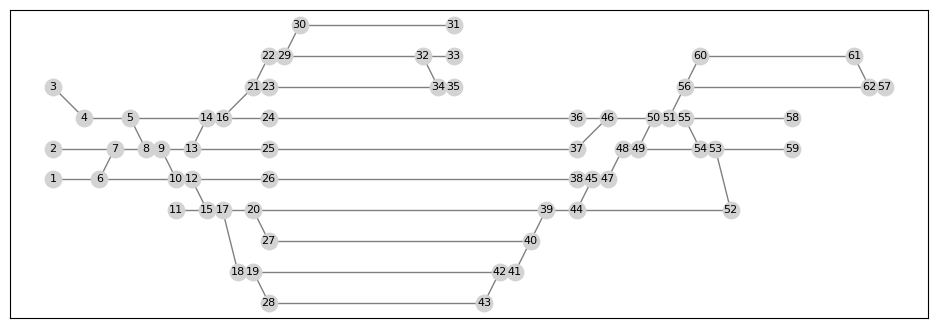

In [32]:
# run_and_animate_from_occupancy.py
import csv
import math
import random
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from datetime import datetime, timedelta

# ----------------------------
# PARAMETERS (tweak if needed)
# ----------------------------
CSV_FILE = 'Book-(Sheet1).csv'
OUT_OCC_CSV = "out.csv"

# coordinate scales (CSV units in cm)
X_SCALE_M_PER_UNIT = 100.0   # x_unit * 100 -> meters
Y_SCALE_M_PER_UNIT = 5.0     # y_unit * 5 -> meters

# train physics
V_MAX_KMPH = 30.0
V_MAX_MPS = (V_MAX_KMPH * 1000.0) / 3600.0
ACCELERATION = 0.6  # m/s^2
TRAIN_LENGTH_M = 400.0

# headways & dwell times (minutes)
HEADWAY_SECTION_MIN = 2.0
HEADWAY_SWITCH_MIN = 5.0
HEADWAY_PLATFORM_MIN = 1.0
DWELL_STOP_MIN = 5.0
DWELL_PASS_MIN = 0.0

MIN_TRAVEL_TIME_MIN = 0.01

# generation & scheduling
ALL_TO_ALL_MODE = "sample"   # "all"|"sample"| "pairs_list"
MAX_TRAINS = 40
INJECTION_GAP_MIN = 1.0

# logging & animation
TIME_RES_SECONDS = 1           # sample every second for smooth animation
ANIM_DURATION_SECONDS = 60.0   # playback length (seconds)
FPS = 20
SAFE_DISTANCE_M = 500.0        # distance threshold to flag conflict (meters)

# randomness / debug
RANDOM_SEED = 42
DEBUG = True
random.seed(RANDOM_SEED)

# ----------------------------
# helpers: physics in seconds
# ----------------------------
def travel_time_seconds(distance_m, v_max=V_MAX_MPS, accel=ACCELERATION):
    # trapezoidal or triangular profile
    t_acc = v_max / accel
    d_acc = 0.5 * accel * t_acc * t_acc
    if d_acc*2 < distance_m:
        d_cruise = distance_m - 2*d_acc
        t_cruise = d_cruise / v_max
        total = t_acc + t_cruise + t_acc
    else:
        total = 2.0 * math.sqrt(max(distance_m, 0.0) / accel)
    return max(total, MIN_TRAVEL_TIME_MIN * 60.0)

def section_times_seconds(xu, yu, xv, yv):
    d = math.hypot(xv - xu, yv - yu)
    t_center = travel_time_seconds(d)                     # front reaches next center
    t_tail = travel_time_seconds(d + TRAIN_LENGTH_M)      # tail clears next center
    return t_center, t_tail, d

# ----------------------------
# Load CSV and build graph
# ----------------------------
G = nx.Graph()
rows = []
with open(CSV_FILE, newline='', encoding='utf-8') as f:
    reader = csv.DictReader(f)
    rows = list(reader)
    if not rows:
        raise RuntimeError("CSV is empty or unreadable")

for row in rows:
    node = str(row['nodes']).strip()
    x_unit = float(row['x'])
    y_unit = float(row['y'])
    xm = x_unit * X_SCALE_M_PER_UNIT
    ym = y_unit * Y_SCALE_M_PER_UNIT
    G.add_node(node, x_unit=x_unit, y_unit=y_unit, xm=xm, ym=ym)

for row in rows:
    node = str(row['nodes']).strip()
    raw_adj = str(row.get('adjacent_connected_node(s)', "")).strip()
    if raw_adj and raw_adj.lower() != 'nan':
        raw_adj = raw_adj.replace('"', '').replace("'", "")
        sep = ',' if ',' in raw_adj else ';' if ';' in raw_adj else ' '
        for tok in [t.strip() for t in raw_adj.split(sep) if t.strip()]:
            if tok not in G:
                G.add_node(tok, x_unit=0.0, y_unit=0.0, xm=0.0, ym=0.0)
            if not G.has_edge(node, tok):
                xu, yu = G.nodes[node]['xm'], G.nodes[node]['ym']
                xv, yv = G.nodes[tok]['xm'], G.nodes[tok]['ym']
                length_m = math.hypot(xv - xu, yv - yu)
                G.add_edge(node, tok, length_m=length_m)

if DEBUG:
    print(f"Graph: nodes={G.number_of_nodes()}, edges={G.number_of_edges()}")

# ----------------------------
# Build OD pairs
# ----------------------------
nodes = list(G.nodes)
if ALL_TO_ALL_MODE == "all":
    pairs = [(s, d) for s in nodes for d in nodes if s != d][:MAX_TRAINS]
elif ALL_TO_ALL_MODE == "sample":
    full_pairs = [(s, d) for s in nodes for d in nodes if s != d]
    pairs = full_pairs if len(full_pairs) <= MAX_TRAINS else random.sample(full_pairs, MAX_TRAINS)
else:
    pairs = [("2","58"), ("3","58"), ("59","1")]

if DEBUG:
    print(f"Scheduling {len(pairs)} trips (mode={ALL_TO_ALL_MODE})")

# ----------------------------
# Scheduler (stores detailed node & section times per train)
# ----------------------------
START_TIME = datetime(2025,8,12,12,0,0)

class Train:
    def __init__(self, tid, route, start_dt, is_stopping=True):
        self.tid = tid
        self.route = route[:]
        self.start_dt = start_dt
        self.is_stopping = is_stopping
        self.node_logs = []       # list of dicts per node [arrival_front, departure_front, arrival_center(next), tail_clear]
        self.section_logs = []    # list of (u,v, section_start, tail_clear)

def schedule_trains(pairs, injection_gap_min=INJECTION_GAP_MIN):
    trains = []
    section_free = {}
    switch_free = {}
    platform_free = {}
    next_injection = START_TIME
    tid = 0

    for s, d in pairs:
        try:
            route = nx.shortest_path(G, s, d)
        except nx.NetworkXNoPath:
            if DEBUG: print("No path", s, d); continue
        tid += 1
        train = Train(tid, route, start_dt=next_injection, is_stopping=(random.random() < 0.7))
        time_cursor = next_injection

        for i, node in enumerate(route):
            xm, ym = G.nodes[node]['xm'], G.nodes[node]['ym']
            arrival_front = time_cursor
            dwell = DWELL_STOP_MIN if train.is_stopping else DWELL_PASS_MIN
            departure_front = arrival_front + timedelta(seconds=dwell * 60.0)

            # platform headway
            pf = platform_free.get(node, START_TIME)
            if arrival_front < pf:
                arrival_front = pf
                departure_front = arrival_front + timedelta(seconds=dwell * 60.0)
            platform_free[node] = departure_front + timedelta(seconds=HEADWAY_PLATFORM_MIN * 60.0)

            # tail clear of node: when front moved TRAIN_LENGTH beyond node center
            tail_clear_node = departure_front + timedelta(seconds=travel_time_seconds(TRAIN_LENGTH_M))

            node_record = {
                'node': node,
                'arrival_front': arrival_front,
                'departure_front': departure_front,
                'node_tail_clear': tail_clear_node,
                'xm': xm, 'ym': ym
            }
            train.node_logs.append(node_record)

            # if moving to next node compute section timing
            if i < len(route) - 1:
                u, v = node, route[i+1]
                xu, yu = G.nodes[u]['xm'], G.nodes[u]['ym']
                xv, yv = G.nodes[v]['xm'], G.nodes[v]['ym']
                t_center_sec, t_tail_sec, dist_m = section_times_seconds(xu, yu, xv, yv)

                # ensure departure respects section and switch frees
                section_key = frozenset({u,v})
                sec_free_dt = section_free.get(section_key, START_TIME)
                if departure_front < sec_free_dt:
                    departure_front = sec_free_dt
                    node_record['departure_front'] = departure_front
                    node_record['node_tail_clear'] = departure_front + timedelta(seconds=travel_time_seconds(TRAIN_LENGTH_M))
                    platform_free[node] = departure_front + timedelta(seconds=HEADWAY_PLATFORM_MIN * 60.0)

                if G.degree(u) >= 3:
                    swf = switch_free.get(u, START_TIME)
                    if departure_front < swf:
                        departure_front = swf
                        node_record['departure_front'] = departure_front
                        node_record['node_tail_clear'] = departure_front + timedelta(seconds=travel_time_seconds(TRAIN_LENGTH_M))
                        platform_free[node] = departure_front + timedelta(seconds=HEADWAY_PLATFORM_MIN * 60.0)
                if G.degree(v) >= 3:
                    swf = switch_free.get(v, START_TIME)
                    if departure_front < swf:
                        departure_front = swf
                        node_record['departure_front'] = departure_front
                        node_record['node_tail_clear'] = departure_front + timedelta(seconds=travel_time_seconds(TRAIN_LENGTH_M))
                        platform_free[node] = departure_front + timedelta(seconds=HEADWAY_PLATFORM_MIN * 60.0)

                # section start and tail clear times
                section_start = departure_front
                section_tail_clear = departure_front + timedelta(seconds=t_tail_sec)
                arrival_center = section_start + timedelta(seconds=t_center_sec)

                # store arrival_center for the *next* node's arrival_front
                # We'll set the next node's arrival_front when iterating to it; for now we can store arrival_center in node_record
                node_record['arrival_center_to_next'] = arrival_center

                train.section_logs.append((u, v, section_start, section_tail_clear, dist_m, t_center_sec, t_tail_sec))

                # update frees
                section_free[section_key] = section_tail_clear + timedelta(seconds=HEADWAY_SECTION_MIN * 60.0)
                if G.degree(u) >= 3:
                    switch_free[u] = section_tail_clear + timedelta(seconds=HEADWAY_SWITCH_MIN * 60.0)
                if G.degree(v) >= 3:
                    switch_free[v] = section_tail_clear + timedelta(seconds=HEADWAY_SWITCH_MIN * 60.0)

                # advance time_cursor to arrival_center for the FRONT arriving at next node
                time_cursor = arrival_center
            else:
                time_cursor = departure_front

        # now fix next node arrival_fronts using stored arrival_centers (we can propagate)
        # iterate node_logs and for each node k (except first) set arrival_front = previous node's arrival_center if that is later
        for k in range(1, len(train.node_logs)):
            prev = train.node_logs[k-1]
            this = train.node_logs[k]
            suggested = prev.get('arrival_center_to_next', None)
            if suggested and this['arrival_front'] < suggested:
                # shift this node arrival & departure accordingly (note: we should also re-check headways, but to keep code simple we accept this)
                delta = suggested - this['arrival_front']
                this['arrival_front'] = suggested
                this['departure_front'] = this['departure_front'] + delta
                this['node_tail_clear'] = this['node_tail_clear'] + delta
                # also shift any later node entries
                for m in range(k+1, len(train.node_logs)):
                    train.node_logs[m]['arrival_front'] = train.node_logs[m]['arrival_front'] + delta
                    train.node_logs[m]['departure_front'] = train.node_logs[m]['departure_front'] + delta
                    train.node_logs[m]['node_tail_clear'] = train.node_logs[m]['node_tail_clear'] + delta
        trains.append(train)
        next_injection = next_injection + timedelta(seconds=injection_gap_min * 60.0)

    return trains

trains = schedule_trains(pairs, injection_gap_min=INJECTION_GAP_MIN)
print(f"Scheduled {len(trains)} trains")

# ----------------------------
# Build per-second movement log across simulation time
# ----------------------------
# determine simulation start & end
sim_start = START_TIME
sim_end = sim_start
for t in trains:
    for nl in t.node_logs:
        sim_end = max(sim_end, nl['node_tail_clear'])
    for sl in t.section_logs:
        sim_end = max(sim_end, sl[3])

total_seconds = int(max(1, (sim_end - sim_start).total_seconds()))
if DEBUG:
    print(f"Sim covers {total_seconds/60.0:.2f} minutes from {sim_start} to {sim_end}")

# map each train into a time-indexed front position (meters) and other attributes
# We'll sample each second between sim_start..sim_end
timestamps = [sim_start + timedelta(seconds=s) for s in range(0, total_seconds+1, TIME_RES_SECONDS)]

# Build helper to get front position at a sim_time
def front_pos_and_meta(train, sim_time):
    # return (x_m, y_m, node_id or None, section_id or None, state_str, entry_time, exit_time)
    # state: 'waiting' (not injected), 'dwell' (at node), 'moving', 'finished'
    if not train.node_logs:
        return None
    first_arr = train.node_logs[0]['arrival_front']
    last_tail = train.node_logs[-1]['node_tail_clear']
    if sim_time < first_arr:
        return None
    if sim_time >= last_tail:
        nl = train.node_logs[-1]
        return (nl['xm'], nl['ym'], nl['node'], None, 'finished', nl['arrival_front'], nl['node_tail_clear'])
    # find where we are
    for i in range(len(train.node_logs)):
        n = train.node_logs[i]
        # in dwell at node?
        if n['arrival_front'] <= sim_time <= n['departure_front']:
            return (n['xm'], n['ym'], n['node'], None, 'dwell', n['arrival_front'], n['departure_front'])
        # moving to next node?
        if i < len(train.node_logs)-1:
            nnext = train.node_logs[i+1]
            dep = n['departure_front']
            arr_center = n.get('arrival_center_to_next', nnext['arrival_front'])
            if dep <= sim_time <= arr_center:
                # interpolate front between n and nnext using their center coordinates in meters
                xm1, ym1 = n['xm'], n['ym']
                xm2, ym2 = nnext['xm'], nnext['ym']
                total = (arr_center - dep).total_seconds()
                if total <= 0:
                    frac = 1.0
                else:
                    frac = (sim_time - dep).total_seconds() / total
                frac = min(max(frac, 0.0), 1.0)
                x_m = xm1 + (xm2 - xm1) * frac
                y_m = ym1 + (ym2 - ym1) * frac
                # entry/exit times for section we can read from section_logs entry for (n.node -> nnext.node)
                sect_id = f"{n['node']}-{nnext['node']}"
                # find section log
                for sl in train.section_logs:
                    if set([sl[0], sl[1]]) == set([n['node'], nnext['node']]):
                        sec_start = sl[2]
                        sec_tail_clear = sl[3]
                        break
                else:
                    sec_start, sec_tail_clear = dep, arr_center + timedelta(seconds=travel_time_seconds(TRAIN_LENGTH_M))
                return (x_m, y_m, None, sect_id, 'moving', sec_start, sec_tail_clear)
    # fallback to last node
    nl = train.node_logs[-1]
    return (nl['xm'], nl['ym'], nl['node'], None, 'finished', nl['arrival_front'], nl['node_tail_clear'])

# Build log rows per timestamp and compute conflicts by distance
records = []
# precompute positions per train per timestamp to speed conflict checks
positions = {t.tid: {} for t in trains}
for sim_t in timestamps:
    # compute position for each train at this sim_t
    for train in trains:
        meta = front_pos_and_meta(train, sim_t)
        if meta is None:
            positions[train.tid][sim_t] = None
            continue
        x_m, y_m, node_id, section_id, state, entry_time, exit_time = meta
        # compute approx speed: if moving, compute average speed between centers (dist / travel_time)
        speed_mps = 0.0
        if state == 'moving' and section_id:
            # parse u,v
            u,v = section_id.split('-')
            xu, yu = G.nodes[u]['xm'], G.nodes[u]['ym']
            xv, yv = G.nodes[v]['xm'], G.nodes[v]['ym']
            # distance center-to-center
            d = math.hypot(xv - xu, yv - yu)
            # compute arrival_center and departure for this section if available
            # find matching section log
            found = None
            for sl in train.section_logs:
                if sl[0] == u and sl[1] == v:
                    found = sl; break
                if sl[0] == v and sl[1] == u:
                    found = sl; break
            if found:
                t_center = found[5]  # stored t_center_sec
                if t_center > 0:
                    speed_mps = d / t_center
                else:
                    speed_mps = V_MAX_MPS
            else:
                speed_mps = V_MAX_MPS
        positions[train.tid][sim_t] = {
            'x_m': x_m, 'y_m': y_m, 'x_unit': x_m / X_SCALE_M_PER_UNIT, 'y_unit': y_m / Y_SCALE_M_PER_UNIT,
            'node': node_id, 'section': section_id, 'state': state,
            'entry_time': entry_time, 'exit_time': exit_time, 'speed_mps': speed_mps
        }
    # compute pairwise conflicts by Euclidean distance (meters)
    # gather active trains positions
    active = [(tid, positions[tid][sim_t]) for tid in positions if positions[tid][sim_t] is not None]
    # compute distances
    conflicts_pairs = {}
    for i in range(len(active)):
        tid_i, pi = active[i]
        xi, yi = pi['x_m'], pi['y_m']
        for j in range(i+1, len(active)):
            tid_j, pj = active[j]
            xj, yj = pj['x_m'], pj['y_m']
            d = math.hypot(xi - xj, yi - yj)
            if d < SAFE_DISTANCE_M:
                conflicts_pairs.setdefault(tid_i, []).append(tid_j)
                conflicts_pairs.setdefault(tid_j, []).append(tid_i)
    # build records for this timestamp
    for tid, pdata in active:
        confs = conflicts_pairs.get(tid, [])
        records.append({
            'timestamp': sim_t.isoformat(),
            'train_id': tid,
            'x_m': pdata['x_m'],
            'y_m': pdata['y_m'],
            'x_unit': pdata['x_unit'],
            'y_unit': pdata['y_unit'],
            'node': pdata['node'] or '',
            'section': pdata['section'] or '',
            'state': pdata['state'],
            'entry_time': pdata['entry_time'].isoformat(),
            'exit_time': pdata['exit_time'].isoformat(),
            'speed_mps': round(pdata['speed_mps'], 3),
            'direction_deg': 0.0,   # we'll compute direction shortly below
            'conflict_flag': 1 if len(confs) > 0 else 0,
            'conflict_with': ",".join(map(str, confs)) if confs else ""
        })

# compute approximate direction per record using small delta: look ahead 1 sec where possible
# build index by train and time for convenience
from collections import defaultdict
index = defaultdict(dict)
for r in records:
    index[r['train_id']][r['timestamp']] = r

# helper to parse iso timestamp to datetime
def parse_iso(ts): return datetime.fromisoformat(ts)

for r in records:
    tid = r['train_id']
    t = parse_iso(r['timestamp'])
    t2 = t + timedelta(seconds=1)
    r2 = index[tid].get(t2.isoformat(), None)
    if r2:
        dx = r2['x_m'] - r['x_m']
        dy = r2['y_m'] - r['y_m']
        deg = math.degrees(math.atan2(dy, dx)) if (dx != 0 or dy != 0) else 0.0
        r['direction_deg'] = round(deg, 2)
    else:
        r['direction_deg'] = 0.0

# save occupancy CSV
fieldnames = ['timestamp','train_id','x_m','y_m','x_unit','y_unit','node','section','state','entry_time','exit_time','speed_mps','direction_deg','conflict_flag','conflict_with']
with open(OUT_OCC_CSV, 'w', newline='', encoding='utf-8') as f:
    writer = csv.DictWriter(f, fieldnames=fieldnames)
    writer.writeheader()
    for r in records:
        writer.writerow(r)
print(f"Wrote occupancy log to {OUT_OCC_CSV} (records: {len(records)})")

# ----------------------------
# ANIMATE using occupancy CSV
# ----------------------------
# Read back (or reuse records)
# We'll build a list of unique timestamps and for each timestamp plot all trains
timestamps_sorted = sorted(list(sorted({r['timestamp'] for r in records})))
# map timestamp string -> datetime
ts_dt = [datetime.fromisoformat(t) for t in timestamps_sorted]

# create mapping timestamp -> list of (train_id, x_unit, y_unit, conflict_flag)
frame_map = {}
for r in records:
    frame_map.setdefault(r['timestamp'], []).append(r)

# plotting in original units (x_unit, y_unit)
x_units = [G.nodes[n]['x_unit'] for n in G.nodes]
y_units = [G.nodes[n]['y_unit'] for n in G.nodes]
xmin, xmax = min(x_units), max(x_units)
ymin, ymax = min(y_units), max(y_units)
xpad = max(0.5, 0.05 * (xmax - xmin + 1.0))
ypad = max(0.5, 0.05 * (ymax - ymin + 1.0))

fig, ax = plt.subplots(figsize=(14,4))
ax.set_xlim(xmin - xpad, xmax + xpad)
ax.set_ylim(ymin - ypad, ymax + ypad)
ax.set_aspect('equal')

pos_units = {n:(G.nodes[n]['x_unit'], G.nodes[n]['y_unit']) for n in G.nodes}
nx.draw_networkx_nodes(G, pos=pos_units, ax=ax, node_color='lightgray', node_size=140)
nx.draw_networkx_edges(G, pos=pos_units, ax=ax, edge_color='gray')
nx.draw_networkx_labels(G, pos=pos_units, ax=ax, font_size=8)

cmap = mpl.colormaps.get_cmap('tab20')
scatter = ax.scatter([], [], s=80, zorder=6)
texts = {}
# prepare ordered list of unique train ids for consistent colors
train_ids = sorted({r['train_id'] for r in records})
train_colors = {tid: cmap(i % 20) for i, tid in enumerate(train_ids)}

# animation mapping: compress sim time to ANIM_DURATION_SECONDS
sim_start = sim_start
sim_end = sim_end
sim_total_seconds = (sim_end - sim_start).total_seconds()
if sim_total_seconds <= 0:
    sim_total_seconds = 1.0
def frame_to_simtime(frame_idx):
    frac = frame_idx / max(1, FRAMES-1)
    return sim_start + timedelta(seconds=frac * sim_total_seconds)

# build a list of frame timestamps closest to sim time values
frame_sim_times = [frame_to_simtime(i) for i in range(FRAMES)]
# for quick lookup, build per-sim-second mapping of records by datetime rounded to second
records_by_dt = {}
for r in records:
    dt = datetime.fromisoformat(r['timestamp'])
    records_by_dt.setdefault(dt, []).append(r)

def find_records_for_simtime(sim_t):
    # either exact match, or nearest earlier second
    key = sim_t
    if key in records_by_dt:
        return records_by_dt[key]
    key = sim_t.replace(microsecond=0)
    if key in records_by_dt:
        return records_by_dt[key]
    # fallback: find the nearest second within +/-1s
    for d in [sim_t - timedelta(seconds=1), sim_t + timedelta(seconds=1)]:
        if d in records_by_dt:
            return records_by_dt[d]
    return []

# initialize artist texts for each train
for tid in train_ids:
    texts[tid] = ax.text(0,0,"", fontsize=8, zorder=7)

def update(frame_idx):
    sim_t = frame_sim_times[frame_idx]
    recs = find_records_for_simtime(sim_t)
    pts = []
    cols = []
    labels = []
    # clear all texts first
    for tid in train_ids:
        texts[tid].set_text("")
    for r in recs:
        x = float(r['x_unit'])
        y = float(r['y_unit'])
        tid = r['train_id']
        conflict = int(r['conflict_flag'])
        color = (1.0, 0.0, 0.0) if conflict else train_colors[tid]
        pts.append((x,y))
        cols.append(color)
        texts[tid].set_position((x + 0.3, y + 0.15))
        texts[tid].set_text(f"T{tid}" if not conflict else f"T{tid}⚠")
    if len(pts) == 0:
        scatter.set_offsets(np.empty((0,2)))
        scatter.set_color([])
    else:
        scatter.set_offsets(pts)
        scatter.set_color(cols)
    ax.set_title(f"Playback @ {sim_t.strftime('%H:%M:%S')} (red = conflict)")
    return (scatter, *texts.values())

ani = mpl.animation.FuncAnimation(fig, update, frames=FRAMES, interval=INTERVAL_MS, blit=False, repeat=False)
plt.show()


Graph built: nodes=62, edges=73
Prepared 120 candidate OD pairs (mode=sample)
Searching max safe trains up to 120 candidates...
Test N=60: conflicts=YES (records=2569643)
Test N=30: conflicts=YES (records=676888)
Test N=15: conflicts=YES (records=152946)
Test N=7: conflicts=YES (records=41612)
Test N=3: conflicts=YES (records=12159)
Test N=1: conflicts=NO (records=2913)
Test N=2: conflicts=YES (records=8166)
Maximum number of trains that can be scheduled safely (no front-front conflict): 1
Wrote occupancy log to out.csv (records: 2913)


TypeError: ColormapRegistry.get_cmap() takes 2 positional arguments but 3 were given

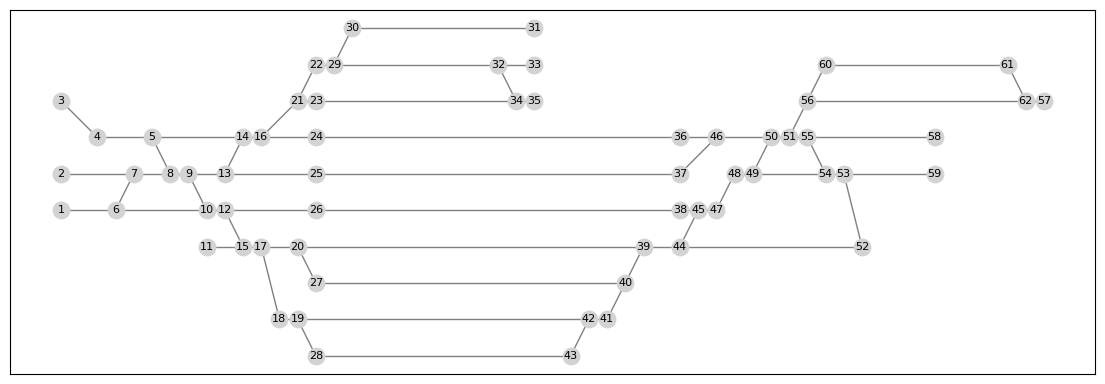

In [39]:
#!/usr/bin/env python3
"""
schedule_and_animate.py

Reads a node CSV (columns: nodes, x, y, adjacent_connected_node(s)),
builds a graph, schedules trains with realistic travel/dwell/headway logic,
searches for the maximum number of trains that can be scheduled without
any front-front conflict (distance < SAFE_DISTANCE_M), writes an occupancy CSV,
and shows an animation of the schedule.

Author: ChatGPT (GPT-5 Thinking mini)
"""

import csv
import math
import random
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.animation as animation
from datetime import datetime, timedelta
from collections import defaultdict

# ----------------------------
# USER-TUNABLE PARAMETERS
# ----------------------------
CSV_FILE = 'Book-(Sheet1).csv'   # input node CSV (must exist)
OUT_OCC_CSV = 'out.csv'          # occupancy output

# coordinate scales (CSV units -> meters)
X_SCALE_M_PER_UNIT = 100.0   # multiply x units by this to get meters
Y_SCALE_M_PER_UNIT = 5.0     # multiply y units by this to get meters

# train physics
V_MAX_KMPH = 30.0
V_MAX_MPS = (V_MAX_KMPH * 1000.0) / 3600.0
ACCELERATION = 0.6  # m/s^2
TRAIN_LENGTH_M = 400.0

# headways & dwell times (minutes)
HEADWAY_SECTION_MIN = 2.0
HEADWAY_SWITCH_MIN = 5.0
HEADWAY_PLATFORM_MIN = 1.0
DWELL_STOP_MIN = 5.0
DWELL_PASS_MIN = 0.0

MIN_TRAVEL_TIME_MIN = 0.01

# scheduling mode & caps
ALL_TO_ALL_MODE = "sample"   # "all" | "sample" | "pairs_list"
MAX_TRAINS_CAP = 120        # hard cap to avoid huge runs
INJECTION_GAP_MIN = 1.0

# conflict threshold (meters)
SAFE_DISTANCE_M = 500.0

# animation parameters
ANIM_DURATION_SECONDS = 60.0   # playback length (seconds)
FPS = 20

# randomness & debug
RANDOM_SEED = 42
DEBUG = True
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

# ----------------------------
# Helper: travel times (seconds)
# ----------------------------
def travel_time_seconds(distance_m, v_max=V_MAX_MPS, accel=ACCELERATION):
    # trapezoidal or triangular profile
    t_acc = v_max / accel
    d_acc = 0.5 * accel * t_acc * t_acc
    if d_acc*2 < distance_m:
        d_cruise = distance_m - 2*d_acc
        t_cruise = d_cruise / v_max
        total = t_acc + t_cruise + t_acc
    else:
        total = 2.0 * math.sqrt(max(distance_m, 0.0) / accel)
    return max(total, MIN_TRAVEL_TIME_MIN * 60.0)

def section_times_seconds(xu, yu, xv, yv):
    d = math.hypot(xv - xu, yv - yu)
    t_center = travel_time_seconds(d)                     # front reaches next center
    t_tail = travel_time_seconds(d + TRAIN_LENGTH_M)      # tail clears next center
    return t_center, t_tail, d

# ----------------------------
# Load CSV and build graph
# ----------------------------
G = nx.Graph()
rows = []
with open(CSV_FILE, newline='', encoding='utf-8') as f:
    reader = csv.DictReader(f)
    rows = list(reader)
    if not rows:
        raise RuntimeError("CSV is empty or unreadable")

# add nodes with scaled coordinates (meters)
for row in rows:
    node = str(row['nodes']).strip()
    x_unit = float(row['x']) if row.get('x', '') != '' else 0.0
    y_unit = float(row['y']) if row.get('y', '') != '' else 0.0
    xm = x_unit * X_SCALE_M_PER_UNIT
    ym = y_unit * Y_SCALE_M_PER_UNIT
    G.add_node(node, x_unit=x_unit, y_unit=y_unit, xm=xm, ym=ym)

# add edges using adjacent_connected_node(s) column (comma/semicolon/space separated)
for row in rows:
    node = str(row['nodes']).strip()
    raw_adj = str(row.get('adjacent_connected_node(s)', "")).strip()
    if raw_adj and raw_adj.lower() != 'nan':
        raw_adj = raw_adj.replace('"', '').replace("'", "")
        sep = ',' if ',' in raw_adj else ';' if ';' in raw_adj else ' '
        for tok in [t.strip() for t in raw_adj.split(sep) if t.strip()]:
            if tok not in G:
                # Add unknown node placeholder (0 coords)
                G.add_node(tok, x_unit=0.0, y_unit=0.0, xm=0.0, ym=0.0)
            if not G.has_edge(node, tok):
                xu, yu = G.nodes[node]['xm'], G.nodes[node]['ym']
                xv, yv = G.nodes[tok]['xm'], G.nodes[tok]['ym']
                length_m = math.hypot(xv - xu, yv - yu)
                G.add_edge(node, tok, length_m=length_m)

if DEBUG:
    print(f"Graph built: nodes={G.number_of_nodes()}, edges={G.number_of_edges()}")

# ----------------------------
# Build OD pairs deterministically (sorted list)
# ----------------------------
nodes = sorted(G.nodes)
full_pairs = [(s, d) for s in nodes for d in nodes if s != d]
if ALL_TO_ALL_MODE == "all":
    pairs_master = full_pairs[:MAX_TRAINS_CAP]
elif ALL_TO_ALL_MODE == "sample":
    # deterministic sample: shuffle with fixed seed and then sort to keep deterministic order
    rnd = random.Random(RANDOM_SEED)
    pairs_copy = full_pairs[:]
    rnd.shuffle(pairs_copy)
    pairs_master = pairs_copy[:min(len(pairs_copy), MAX_TRAINS_CAP)]
else:
    # if user had a pairs_list mode, provide some example pairs (fallback)
    pairs_master = full_pairs[:min(len(full_pairs), MAX_TRAINS_CAP)]

if DEBUG:
    print(f"Prepared {len(pairs_master)} candidate OD pairs (mode={ALL_TO_ALL_MODE})")

# ----------------------------
# Scheduler (same structure you used)
# ----------------------------
START_TIME = datetime.now().replace(hour=12, minute=0, second=0, microsecond=0)

class Train:
    def __init__(self, tid, route, start_dt, is_stopping=True):
        self.tid = tid
        self.route = route[:]
        self.start_dt = start_dt
        self.is_stopping = is_stopping
        self.node_logs = []       # per-node dicts
        self.section_logs = []    # (u,v, section_start, tail_clear, dist_m, t_center_sec, t_tail_sec)

def schedule_trains_from_pairs(pairs, injection_gap_min=INJECTION_GAP_MIN):
    trains = []
    section_free = {}
    switch_free = {}
    platform_free = {}
    next_injection = START_TIME
    tid = 0

    for s,d in pairs:
        try:
            route = nx.shortest_path(G, s, d)
        except nx.NetworkXNoPath:
            if DEBUG: print("No path", s, d); continue
        tid += 1
        train = Train(tid, route, start_dt=next_injection, is_stopping=(random.random() < 0.7))
        time_cursor = next_injection

        for i, node in enumerate(route):
            xm, ym = G.nodes[node]['xm'], G.nodes[node]['ym']
            arrival_front = time_cursor
            dwell = DWELL_STOP_MIN if train.is_stopping else DWELL_PASS_MIN
            departure_front = arrival_front + timedelta(seconds=dwell * 60.0)

            # platform headway
            pf = platform_free.get(node, START_TIME)
            if arrival_front < pf:
                arrival_front = pf
                departure_front = arrival_front + timedelta(seconds=dwell * 60.0)
            platform_free[node] = departure_front + timedelta(seconds=HEADWAY_PLATFORM_MIN * 60.0)

            # tail clear of node: when front moved TRAIN_LENGTH beyond node center
            tail_clear_node = departure_front + timedelta(seconds=travel_time_seconds(TRAIN_LENGTH_M))

            node_record = {
                'node': node,
                'arrival_front': arrival_front,
                'departure_front': departure_front,
                'node_tail_clear': tail_clear_node,
                'xm': xm, 'ym': ym
            }
            train.node_logs.append(node_record)

            # if moving to next node compute section timing
            if i < len(route) - 1:
                u, v = node, route[i+1]
                xu, yu = G.nodes[u]['xm'], G.nodes[u]['ym']
                xv, yv = G.nodes[v]['xm'], G.nodes[v]['ym']
                t_center_sec, t_tail_sec, dist_m = section_times_seconds(xu, yu, xv, yv)

                # ensure departure respects section and switch frees
                section_key = frozenset({u,v})
                sec_free_dt = section_free.get(section_key, START_TIME)
                if departure_front < sec_free_dt:
                    departure_front = sec_free_dt
                    node_record['departure_front'] = departure_front
                    node_record['node_tail_clear'] = departure_front + timedelta(seconds=travel_time_seconds(TRAIN_LENGTH_M))
                    platform_free[node] = departure_front + timedelta(seconds=HEADWAY_PLATFORM_MIN * 60.0)

                if G.degree(u) >= 3:
                    swf = switch_free.get(u, START_TIME)
                    if departure_front < swf:
                        departure_front = swf
                        node_record['departure_front'] = departure_front
                        node_record['node_tail_clear'] = departure_front + timedelta(seconds=travel_time_seconds(TRAIN_LENGTH_M))
                        platform_free[node] = departure_front + timedelta(seconds=HEADWAY_PLATFORM_MIN * 60.0)
                if G.degree(v) >= 3:
                    swf = switch_free.get(v, START_TIME)
                    if departure_front < swf:
                        departure_front = swf
                        node_record['departure_front'] = departure_front
                        node_record['node_tail_clear'] = departure_front + timedelta(seconds=travel_time_seconds(TRAIN_LENGTH_M))
                        platform_free[node] = departure_front + timedelta(seconds=HEADWAY_PLATFORM_MIN * 60.0)

                # section start and tail clear times
                section_start = departure_front
                section_tail_clear = departure_front + timedelta(seconds=t_tail_sec)
                arrival_center = section_start + timedelta(seconds=t_center_sec)

                node_record['arrival_center_to_next'] = arrival_center
                train.section_logs.append((u, v, section_start, section_tail_clear, dist_m, t_center_sec, t_tail_sec))

                # update frees
                section_free[section_key] = section_tail_clear + timedelta(seconds=HEADWAY_SECTION_MIN * 60.0)
                if G.degree(u) >= 3:
                    switch_free[u] = section_tail_clear + timedelta(seconds=HEADWAY_SWITCH_MIN * 60.0)
                if G.degree(v) >= 3:
                    switch_free[v] = section_tail_clear + timedelta(seconds=HEADWAY_SWITCH_MIN * 60.0)

                # advance time_cursor to arrival_center for the FRONT arriving at next node
                time_cursor = arrival_center
            else:
                time_cursor = departure_front

        # propagate arrival_center_to_next shifts to later nodes if needed
        for k in range(1, len(train.node_logs)):
            prev = train.node_logs[k-1]
            this = train.node_logs[k]
            suggested = prev.get('arrival_center_to_next', None)
            if suggested and this['arrival_front'] < suggested:
                delta = suggested - this['arrival_front']
                this['arrival_front'] = suggested
                this['departure_front'] = this['departure_front'] + delta
                this['node_tail_clear'] = this['node_tail_clear'] + delta
                for m in range(k+1, len(train.node_logs)):
                    train.node_logs[m]['arrival_front'] = train.node_logs[m]['arrival_front'] + delta
                    train.node_logs[m]['departure_front'] = train.node_logs[m]['departure_front'] + delta
                    train.node_logs[m]['node_tail_clear'] = train.node_logs[m]['node_tail_clear'] + delta

        trains.append(train)
        next_injection = next_injection + timedelta(seconds=injection_gap_min * 60.0)

    return trains

# ----------------------------
# Simulation & occupancy builder (per-second) and conflict checker
# ----------------------------
def build_occupancy_and_conflicts(trains):
    # Determine sim start & end
    sim_start = START_TIME
    sim_end = sim_start
    for t in trains:
        for nl in t.node_logs:
            sim_end = max(sim_end, nl['node_tail_clear'])
        for sl in t.section_logs:
            sim_end = max(sim_end, sl[3])
    total_seconds = int(max(1, (sim_end - sim_start).total_seconds()))
    timestamps = [sim_start + timedelta(seconds=s) for s in range(0, total_seconds+1)]

    # helper to get front pos (x_m, y_m ...) for a train at sim_time
    def front_pos_and_meta(train, sim_time):
        if not train.node_logs:
            return None
        first_arr = train.node_logs[0]['arrival_front']
        last_tail = train.node_logs[-1]['node_tail_clear']
        if sim_time < first_arr:
            return None
        if sim_time >= last_tail:
            nl = train.node_logs[-1]
            return (nl['xm'], nl['ym'], nl['node'], None, 'finished', nl['arrival_front'], nl['node_tail_clear'])
        for i in range(len(train.node_logs)):
            n = train.node_logs[i]
            if n['arrival_front'] <= sim_time <= n['departure_front']:
                return (n['xm'], n['ym'], n['node'], None, 'dwell', n['arrival_front'], n['departure_front'])
            if i < len(train.node_logs)-1:
                nnext = train.node_logs[i+1]
                dep = n['departure_front']
                arr_center = n.get('arrival_center_to_next', nnext['arrival_front'])
                if dep <= sim_time <= arr_center:
                    xm1, ym1 = n['xm'], n['ym']
                    xm2, ym2 = nnext['xm'], nnext['ym']
                    total = (arr_center - dep).total_seconds()
                    if total <= 0:
                        frac = 1.0
                    else:
                        frac = (sim_time - dep).total_seconds() / total
                    frac = min(max(frac, 0.0), 1.0)
                    x_m = xm1 + (xm2 - xm1) * frac
                    y_m = ym1 + (ym2 - ym1) * frac
                    sect_id = f"{n['node']}-{nnext['node']}"
                    # find section log
                    for sl in train.section_logs:
                        if set([sl[0], sl[1]]) == set([n['node'], nnext['node']]):
                            sec_start = sl[2]
                            sec_tail_clear = sl[3]
                            t_center_sec = sl[5]
                            break
                    else:
                        sec_start, sec_tail_clear = dep, arr_center + timedelta(seconds=travel_time_seconds(TRAIN_LENGTH_M))
                        t_center_sec = (arr_center - dep).total_seconds()
                    speed_mps = 0.0
                    if t_center_sec > 0:
                        speed_mps = sl[4] / t_center_sec if 'sl' in locals() else 0.0
                    return (x_m, y_m, None, sect_id, 'moving', sec_start, sec_tail_clear)
        nl = train.node_logs[-1]
        return (nl['xm'], nl['ym'], nl['node'], None, 'finished', nl['arrival_front'], nl['node_tail_clear'])

    records = []
    positions = {t.tid: {} for t in trains}
    for sim_t in timestamps:
        active = []
        for train in trains:
            meta = front_pos_and_meta(train, sim_t)
            if meta is None:
                positions[train.tid][sim_t] = None
                continue
            x_m, y_m, node_id, section_id, state, entry_time, exit_time = meta
            speed_mps = 0.0
            positions[train.tid][sim_t] = {
                'x_m': x_m, 'y_m': y_m, 'x_unit': x_m / X_SCALE_M_PER_UNIT, 'y_unit': y_m / Y_SCALE_M_PER_UNIT,
                'node': node_id, 'section': section_id, 'state': state,
                'entry_time': entry_time, 'exit_time': exit_time, 'speed_mps': speed_mps
            }
            active.append((train.tid, positions[train.tid][sim_t]))

        # pairwise conflicts
        conflicts_pairs = {}
        for i in range(len(active)):
            tid_i, pi = active[i]
            xi, yi = pi['x_m'], pi['y_m']
            for j in range(i+1, len(active)):
                tid_j, pj = active[j]
                xj, yj = pj['x_m'], pj['y_m']
                d = math.hypot(xi - xj, yi - yj)
                if d < SAFE_DISTANCE_M:
                    conflicts_pairs.setdefault(tid_i, []).append(tid_j)
                    conflicts_pairs.setdefault(tid_j, []).append(tid_i)

        for tid, pdata in active:
            confs = conflicts_pairs.get(tid, [])
            records.append({
                'timestamp': sim_t.isoformat(),
                'train_id': tid,
                'x_m': pdata['x_m'],
                'y_m': pdata['y_m'],
                'x_unit': pdata['x_unit'],
                'y_unit': pdata['y_unit'],
                'node': pdata['node'] or '',
                'section': pdata['section'] or '',
                'state': pdata['state'],
                'entry_time': pdata['entry_time'].isoformat(),
                'exit_time': pdata['exit_time'].isoformat(),
                'speed_mps': round(pdata['speed_mps'], 3),
                'direction_deg': 0.0,
                'conflict_flag': 1 if len(confs) > 0 else 0,
                'conflict_with': ",".join(map(str, confs)) if confs else ""
            })

    # compute direction by looking 1 sec ahead
    index = defaultdict(dict)
    for r in records:
        index[r['train_id']][r['timestamp']] = r
    def parse_iso(ts): return datetime.fromisoformat(ts)
    for r in records:
        tid = r['train_id']
        t = parse_iso(r['timestamp'])
        t2 = t + timedelta(seconds=1)
        r2 = index[tid].get(t2.isoformat(), None)
        if r2:
            dx = r2['x_m'] - r['x_m']; dy = r2['y_m'] - r['y_m']
            deg = math.degrees(math.atan2(dy, dx)) if (dx != 0 or dy != 0) else 0.0
            r['direction_deg'] = round(deg, 2)
    return records

# ----------------------------
# Determine max safe trains (monotonic search)
# ----------------------------
def find_max_safe_trains(max_try=len(pairs_master)):
    max_try = min(max_try, len(pairs_master))
    if max_try <= 0:
        return 0, []
    low, high = 0, max_try
    safe_trains_schedule = []
    # We'll do binary search (deterministic pairs_master[:N])
    while low < high:
        mid = (low + high + 1) // 2  # try mid trains
        pairs_try = pairs_master[:mid]
        trains = schedule_trains_from_pairs(pairs_try)
        records = build_occupancy_and_conflicts(trains)
        # if any conflict_flag==1 -> unsafe
        any_conflict = any(r['conflict_flag'] == 1 for r in records)
        if DEBUG:
            print(f"Test N={mid}: conflicts={'YES' if any_conflict else 'NO'} (records={len(records)})")
        if any_conflict:
            high = mid - 1
        else:
            low = mid
            safe_trains_schedule = trains  # keep this schedule as current best
    return low, safe_trains_schedule

if __name__ == '__main__':
    # limit tries to avoid very long runs
    tries = min(MAX_TRAINS_CAP, len(pairs_master))
    print(f"Searching max safe trains up to {tries} candidates...")
    max_safe, safe_schedule_trains = find_max_safe_trains(max_try=tries)
    print(f"Maximum number of trains that can be scheduled safely (no front-front conflict): {max_safe}")

    # if none safe, still try to schedule a small number to show output
    if max_safe == 0:
        example_pairs = pairs_master[:min(3, len(pairs_master))]
        safe_schedule_trains = schedule_trains_from_pairs(example_pairs)

    # Build occupancy records for the final schedule, write CSV
    final_records = build_occupancy_and_conflicts(safe_schedule_trains)
    fieldnames = ['timestamp','train_id','x_m','y_m','x_unit','y_unit','node','section','state','entry_time','exit_time','speed_mps','direction_deg','conflict_flag','conflict_with']
    with open(OUT_OCC_CSV, 'w', newline='', encoding='utf-8') as f:
        writer = csv.DictWriter(f, fieldnames=fieldnames)
        writer.writeheader()
        for r in final_records:
            writer.writerow(r)
    print(f"Wrote occupancy log to {OUT_OCC_CSV} (records: {len(final_records)})")

    # ----------------------------
    # ANIMATE the final schedule
    # ----------------------------
    if not final_records:
        print("No records to animate.")
        exit(0)

    # Prepare animation frames (unique timestamps)
    timestamps_sorted = sorted({r['timestamp'] for r in final_records})
    ts_dt = [datetime.fromisoformat(t) for t in timestamps_sorted]
    records_by_dt = defaultdict(list)
    for r in final_records:
        records_by_dt[datetime.fromisoformat(r['timestamp'])].append(r)

    # animation frame mapping
    FRAMES = int(ANIM_DURATION_SECONDS * FPS)
    INTERVAL_MS = int(1000 / FPS)

    sim_start = min(ts_dt)
    sim_end = max(ts_dt)
    sim_total_seconds = (sim_end - sim_start).total_seconds() if sim_end > sim_start else 1.0

    def frame_to_simtime(frame_idx):
        frac = frame_idx / max(1, FRAMES - 1)
        return sim_start + timedelta(seconds=frac * sim_total_seconds)

    # plotting in CSV units (x_unit,y_unit)
    # derive node units for plotting bounds
    x_units = [G.nodes[n]['x_unit'] for n in G.nodes]
    y_units = [G.nodes[n]['y_unit'] for n in G.nodes]
    xmin, xmax = min(x_units), max(x_units)
    ymin, ymax = min(y_units), max(y_units)
    xpad = max(0.5, 0.05 * (xmax - xmin + 1.0))
    ypad = max(0.5, 0.05 * (ymax - ymin + 1.0))

    fig, ax = plt.subplots(figsize=(14,6))
    ax.set_xlim(xmin - xpad, xmax + xpad)
    ax.set_ylim(ymin - ypad, ymax + ypad)
    ax.set_aspect('equal')

    pos_units = {n:(G.nodes[n]['x_unit'], G.nodes[n]['y_unit']) for n in G.nodes}
    nx.draw_networkx_nodes(G, pos=pos_units, ax=ax, node_color='lightgray', node_size=140)
    nx.draw_networkx_edges(G, pos=pos_units, ax=ax, edge_color='gray')
    nx.draw_networkx_labels(G, pos=pos_units, ax=ax, font_size=8)

    # train list, colors, artists
    train_ids = sorted({r['train_id'] for r in final_records})
    cmap = mpl.colormaps.get_cmap('tab20', max(1, len(train_ids)))
    train_colors = {tid: cmap(i % 20) for i, tid in enumerate(train_ids)}

    scatter = ax.scatter([], [], s=90, zorder=6)
    texts = {}
    for tid in train_ids:
        texts[tid] = ax.text(0,0,"", fontsize=9, zorder=7, weight='bold')

    # build list of sim times for frames
    frame_sim_times = [frame_to_simtime(i) for i in range(FRAMES)]

    # quick lookup: map datetime->records (rounded to second)
    records_by_second = defaultdict(list)
    for r in final_records:
        dt = datetime.fromisoformat(r['timestamp']).replace(microsecond=0)
        records_by_second[dt].append(r)

    def find_records_for_simtime(sim_t):
        key = sim_t.replace(microsecond=0)
        if key in records_by_second:
            return records_by_second[key]
        # fallback nearest within +/-1s
        for d in (key - timedelta(seconds=1), key + timedelta(seconds=1)):
            if d in records_by_second:
                return records_by_second[d]
        return []

    def update(frame_idx):
        sim_t = frame_sim_times[frame_idx]
        recs = find_records_for_simtime(sim_t)
        pts = []
        cols = []
        labels = []
        # clear labels
        for tid in train_ids:
            texts[tid].set_text("")
        for r in recs:
            x = float(r['x_unit']); y = float(r['y_unit'])
            tid = r['train_id']
            conflict = int(r['conflict_flag'])
            color = (1.0, 0.0, 0.0, 1.0) if conflict else train_colors[tid]
            pts.append((x,y)); cols.append(color)
            texts[tid].set_position((x + 0.15, y + 0.1))
            texts[tid].set_text(f"T{tid}" + (" ⚠" if conflict else ""))
            texts[tid].set_color(color)
        if len(pts) == 0:
            scatter.set_offsets(np.empty((0,2)))
            scatter.set_color([])
        else:
            scatter.set_offsets(pts)
            scatter.set_color(cols)
        ax.set_title(f"Playback @ {sim_t.strftime('%Y-%m-%d %H:%M:%S')} (red = conflict)")
        return (scatter, *texts.values())

    ani = animation.FuncAnimation(fig, update, frames=FRAMES, interval=INTERVAL_MS, blit=False, repeat=False)
    plt.show()


MovieWriter ffmpeg unavailable; using Pillow instead.


Building edges from nodes.csv adjacency column.
Graph: nodes=62, edges=73
No angle-valid path 54->34, skipping
No angle-valid path 39->10, skipping
No angle-valid path 19->57, skipping
No angle-valid path 55->52, skipping
No angle-valid path 33->12, skipping
No angle-valid path 22->10, skipping
No angle-valid path 42->15, skipping
No angle-valid path 28->35, skipping
No angle-valid path 33->17, skipping
No angle-valid path 51->41, skipping
No angle-valid path 15->33, skipping
No angle-valid path 54->32, skipping
No angle-valid path 51->40, skipping
No angle-valid path 7->16, skipping
No angle-valid path 2->14, skipping
No angle-valid path 48->4, skipping
No angle-valid path 27->11, skipping
No angle-valid path 21->38, skipping
No angle-valid path 37->8, skipping
No angle-valid path 36->53, skipping
No angle-valid path 26->36, skipping
No angle-valid path 22->58, skipping
No angle-valid path 27->35, skipping
No angle-valid path 31->59, skipping
No angle-valid path 33->52, skipping
No an

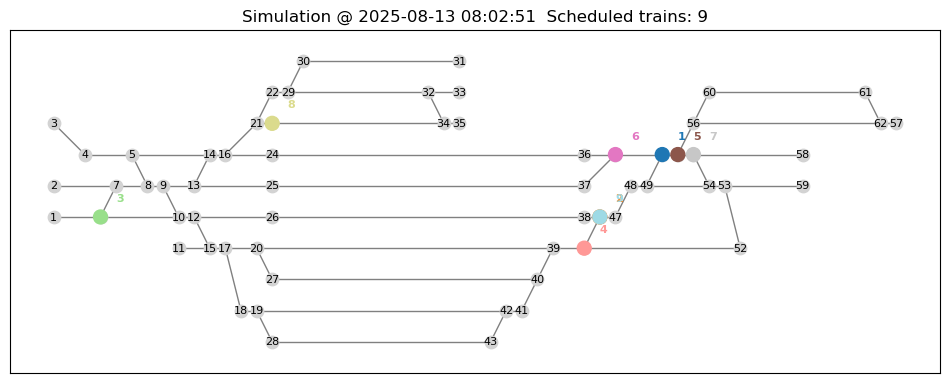

In [1]:
#!/usr/bin/env python3
"""
route_schedule_animate.py

- Reads nodes.csv (nodes,x,y, adjacent_connected_node(s) optional)
- Optionally reads edges.csv (from,to,length_m) if present
- Builds a bidirectional graph and edge lengths
- Finds shortest paths between OD pairs but only allows turns with angle >= 90 deg
- Greedily schedules trains respecting:
    - speed = 8 m/s
    - same-direction headway = 600 s (10 minutes)
    - opposite-direction: no overlap on same segment
- Outputs out.csv (occupancy) and animates the scheduled trains.

Author: ChatGPT (GPT-5 Thinking mini)
"""
import os
import csv
import math
import heapq
import random
from datetime import datetime, timedelta
from collections import defaultdict, deque

import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.animation as animation

# ----------------------------
# USER PARAMETERS
# ----------------------------
NODES_CSV = 'Book-(Sheet1).csv'            # expected columns: nodes,x,y,[adjacent_connected_node(s)]
EDGES_CSV = "edges.csv"            # optional: from,to,length_m (if present used)
OUT_OCC_CSV = "out.csv"

SPEED_MPS = 8.0                    # 8 m/s (~28.8 km/h)
HEADWAY_S = 600                     # 10 minutes in seconds
TRAIN_LENGTH_M = 400.0              # used to compute tail-clear times (can be tuned)
MAX_TRAINS_CAP = 200                # try at most this many candidate OD pairs / trains
MAX_START_SEARCH_HOURS = 6          # when placing a train, search start time up to this many hours
START_TIME = datetime.now().replace(hour=8, minute=0, second=0, microsecond=0)  # scheduling day/time

ANIM_DURATION_SECONDS = 60.0
FPS = 20

RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

DEBUG = True

# ----------------------------
# Utilities
# ----------------------------
def dist_m(p, q):
    return math.hypot(p[0] - q[0], p[1] - q[1])

def angle_between(prev, cur, nxt):
    """
    Angle (degrees) between vector (cur - prev) and (nxt - cur).
    Returned in range [0, 180]. We consider the smaller angle.
    """
    v1 = (cur[0] - prev[0], cur[1] - prev[1])
    v2 = (nxt[0] - cur[0], nxt[1] - cur[1])
    # zero-length guard
    n1 = math.hypot(v1[0], v1[1])
    n2 = math.hypot(v2[0], v2[1])
    if n1 == 0 or n2 == 0:
        return 180.0
    dot = (v1[0]*v2[0] + v1[1]*v2[1]) / (n1*n2)
    dot = max(-1.0, min(1.0, dot))
    ang = math.degrees(math.acos(dot))
    return ang

# ----------------------------
# Load nodes and edges
# ----------------------------
if not os.path.exists(NODES_CSV):
    raise FileNotFoundError(f"{NODES_CSV} not found. Provide nodes.csv with columns nodes,x,y.")

# read nodes
nodes = {}
with open(NODES_CSV, newline='', encoding='utf-8') as f:
    reader = csv.DictReader(f)
    for r in reader:
        node = str(r.get('nodes') or r.get('id') or r.get('node')).strip()
        x = float(r.get('x') or r.get('lon') or r.get('lon_degrees') or 0.0)
        y = float(r.get('y') or r.get('lat') or r.get('lat_degrees') or 0.0)
        adj = r.get('adjacent_connected_node(s)', "") or r.get('adjacent', "") or r.get('adj')
        nodes[node] = {'x': x, 'y': y, 'adj': adj}

# read edges if available else build from adj column
G = nx.Graph()
for n, v in nodes.items():
    G.add_node(n, x=v['x'], y=v['y'])

if os.path.exists(EDGES_CSV):
    if DEBUG: print("Using edges.csv for connectivity.")
    with open(EDGES_CSV, newline='', encoding='utf-8') as f:
        reader = csv.DictReader(f)
        for r in reader:
            u = str(r.get('from')).strip()
            v = str(r.get('to')).strip()
            lm = r.get('length_m')
            if lm is None or lm == "":
                if u in nodes and v in nodes:
                    lm = dist_m((nodes[u]['x'], nodes[u]['y']), (nodes[v]['x'], nodes[v]['y']))
                else:
                    continue
            else:
                lm = float(lm)
            # add bidirectional
            G.add_edge(u, v, length_m=lm)
else:
    # parse adjacency column (commas, semicolons or spaces)
    if DEBUG: print("Building edges from nodes.csv adjacency column.")
    for n, v in nodes.items():
        raw = (v.get('adj') or "").strip()
        if not raw:
            continue
        san = raw.replace('"', '').replace("'", "")
        sep = ',' if ',' in san else ';' if ';' in san else ' '
        for tok in [t.strip() for t in san.split(sep) if t.strip()]:
            if tok not in nodes:
                # create placeholder node at (0,0) if not present
                nodes.setdefault(tok, {'x': 0.0, 'y': 0.0, 'adj': ""})
                G.add_node(tok, x=0.0, y=0.0)
            if not G.has_edge(n, tok):
                lm = dist_m((nodes[n]['x'], nodes[n]['y']), (nodes[tok]['x'], nodes[tok]['y']))
                G.add_edge(n, tok, length_m=lm)

if DEBUG:
    print(f"Graph: nodes={G.number_of_nodes()}, edges={G.number_of_edges()}")

# ----------------------------
# Pathfinding with angle constraint (Dijkstra variant)
# ----------------------------
def shortest_path_with_turn_constraint(G, source, target, allow_angle_deg_min=90.0):
    """
    Return shortest path (by length) from source to target where each internal turn
    has angle >= allow_angle_deg_min (i.e., no acute turns if allow_angle_deg_min=90).
    If no such path exists, return None.
    Uses Dijkstra but state includes previous node to check angles.
    """
    if source == target:
        return [source]
    # priority queue: (dist_so_far, current_node, prev_node, path_list)
    pq = []
    # For starting node, prev_node is None (no angle check for first step)
    heapq.heappush(pq, (0.0, source, None, [source]))
    # visited best distances: (node, prev) -> dist
    best = {}
    while pq:
        dist_so_far, cur, prev, path = heapq.heappop(pq)
        if (cur, prev) in best and best[(cur, prev)] <= dist_so_far:
            continue
        best[(cur, prev)] = dist_so_far
        if cur == target:
            return path
        for nb in G.neighbors(cur):
            if prev is None:
                # first step: always allowed
                new_dist = dist_so_far + G.edges[cur, nb]['length_m']
                new_path = path + [nb]
                key = (nb, cur)
                if key not in best or best[key] > new_dist:
                    heapq.heappush(pq, (new_dist, nb, cur, new_path))
            else:
                # compute angle at 'cur' between prev->cur and cur->nb
                prev_coord = (G.nodes[prev]['x'], G.nodes[prev]['y'])
                cur_coord  = (G.nodes[cur]['x'], G.nodes[cur]['y'])
                nb_coord   = (G.nodes[nb]['x'], G.nodes[nb]['y'])
                ang = angle_between(prev_coord, cur_coord, nb_coord)
                # allow if angle >= threshold (i.e., no acute turns if threshold==90)
                if ang + 1e-6 >= allow_angle_deg_min:
                    new_dist = dist_so_far + G.edges[cur, nb]['length_m']
                    new_path = path + [nb]
                    key = (nb, cur)
                    if key not in best or best[key] > new_dist:
                        heapq.heappush(pq, (new_dist, nb, cur, new_path))
                else:
                    # disallowed acute turn
                    continue
    return None

# ----------------------------
# Build candidate OD pairs (exclude same-node)
# ----------------------------
nodes_list = list(G.nodes)
pairs = [(s, d) for s in nodes_list for d in nodes_list if s != d]
# To avoid huge runs, sample deterministically
rnd = random.Random(RANDOM_SEED)
rnd.shuffle(pairs)
pairs = pairs[:MAX_TRAINS_CAP]

# Precompute routes for candidate pairs (skip pairs with no valid angle-constrained route)
candidate_routes = []
for s, d in pairs:
    path = shortest_path_with_turn_constraint(G, s, d, allow_angle_deg_min=90.0)
    if path is None:
        if DEBUG:
            print(f"No angle-valid path {s}->{d}, skipping")
        continue
    # compute per-edge sequence and times at unit speed (we convert to seconds using SPEED_MPS)
    edges = []
    total_len = 0.0
    for i in range(len(path)-1):
        u, v = path[i], path[i+1]
        lm = G.edges[u, v]['length_m']
        edges.append((u, v, lm))
        total_len += lm
    if len(edges) == 0:
        continue
    candidate_routes.append({'od': (s,d), 'path': path, 'edges': edges, 'length_m': total_len})

if DEBUG:
    print(f"Candidate routes found: {len(candidate_routes)} out of {len(pairs)} pairs")

# ----------------------------
# Scheduling: Greedy earliest-fit on segments
# ----------------------------
# We'll model each undirected segment as an ID (frozenset({u,v})) and track its occupancy intervals:
# occupancy[seg][direction] = list of (entry_time, exit_time) sorted
# direction we'll represent as +1 if trav from u->v as in edge tuple, -1 for v->u

def schedule_greedy(routes, start_time=START_TIME, headway_s=HEADWAY_S, speed_mps=SPEED_MPS,
                    max_start_search_hours=MAX_START_SEARCH_HOURS):
    scheduled = []  # list of dicts: {'route': route, 'start_time': dt, 'edge_times': [(u,v,entry,exit,dir)]}
    occupancy = defaultdict(lambda: {+1: [], -1: []})  # per-segment occupancy lists
    horizon = start_time + timedelta(hours=max_start_search_hours)

    def segment_id(u, v):
        return frozenset({u, v})

    # helper to check if a proposed segment occupancy is safe
    def can_place_segment(seg, direction, entry_t, exit_t):
        # same direction: require new entry >= last_entry + headway OR ensure headway between entries
        # implement conservative rule: for same direction, ensure that for every existing interval (e1,e2),
        # either entry_t >= e1 + headway_s OR e2 <= entry_t (i.e., don't start too soon).
        existing_same = occupancy[seg][direction]
        for (e1, e2) in existing_same:
            # ensure headway between entry times: new entry >= e1 + headway OR existing entry >= entry_t + headway
            if not (entry_t >= e1 + timedelta(seconds=headway_s) or e2 <= entry_t):
                return False
        # opposite direction: no overlap allowed between [entry_t, exit_t] and any opposite intervals
        existing_opp = occupancy[seg][-direction]
        for (o1, o2) in existing_opp:
            if not (exit_t <= o1 or entry_t >= o2):
                return False
        return True

    # helper to register occupancy
    def add_segment(seg, direction, entry_t, exit_t):
        occupancy[seg][direction].append((entry_t, exit_t))

    # iterate routes and try to place each train earliest
    for route in routes:
        # compute per-edge travel times for this route (assuming front moves at SPEED_MPS, tail adds TRAIN_LENGTH)
        edges = route['edges']  # list of (u,v,length_m)
        # compute per-edge travel durations for front: t = length / speed
        edge_durations = [lm / speed_mps for (_,_,lm) in edges]
        # tail extension: additional time for tail to clear next node = TRAIN_LENGTH_M / speed
        tail_clear_add = TRAIN_LENGTH_M / speed_mps

        # search start time from start_time to horizon in increments (we'll use 60s step)
        placed = False
        step = timedelta(seconds=60)
        t_try = start_time
        while t_try <= horizon:
            ok = True
            # compute times when front enters and leaves each segment as it traverses
            times = []  # list of (u,v, entry_time_front, exit_time_front, direction_sign)
            cur_t = t_try
            for idx, (u, v, lm) in enumerate(edges):
                dir_sign = +1  # we treat as direction u->v as +1
                # entry time for front into this segment is cur_t (front departs previous node into seg)
                entry_front = cur_t
                travel_sec = edge_durations[idx]
                exit_front = entry_front + timedelta(seconds=travel_sec)
                # tail_clear_time: when tail clears the segment end (we use exit_front + tail_clear_add)
                tail_clear = exit_front + timedelta(seconds=tail_clear_add)
                seg = segment_id(u, v)
                if not can_place_segment(seg, dir_sign, entry_front, tail_clear):
                    ok = False
                    break
                # advance cur_t to arrival center for next node (exit_front)
                cur_t = exit_front
                times.append((u, v, entry_front, tail_clear, dir_sign))
            if ok:
                # reserve occupancy on all segments
                for (u, v, entry_front, tail_clear, dir_sign) in times:
                    seg = segment_id(u, v)
                    add_segment(seg, dir_sign, entry_front, tail_clear)
                scheduled.append({'route': route, 'start_time': t_try, 'edge_times': times})
                placed = True
                if DEBUG:
                    print(f"Placed train {len(scheduled)} {route['od']} start={t_try} len={route['length_m']:.1f}m")
                break
            t_try += step
        if not placed:
            if DEBUG:
                print(f"Could not place route {route['od']} within horizon starting at {start_time}")
        # stop early if we've reached cap
        if len(scheduled) >= MAX_TRAINS_CAP:
            break
    return scheduled

# ----------------------------
# Try scheduling with greedy order; to maximize count we can try sorting heuristics:
# - short routes first (pack many short trains)
# - long routes first (avoid blocking)
# We'll attempt short-first and see the count.
# ----------------------------
routes_sorted_short = sorted(candidate_routes, key=lambda r: r['length_m'])
scheduled_short = schedule_greedy(routes_sorted_short)

# also try random ordering (to see if we can do better)
routes_random = candidate_routes[:]
random.shuffle(routes_random)
scheduled_random = schedule_greedy(routes_random)

# pick the better schedule
if len(scheduled_random) > len(scheduled_short):
    scheduled = scheduled_random
    if DEBUG: print(f"Random ordering produced better count: {len(scheduled)} vs short-first {len(scheduled_short)}")
else:
    scheduled = scheduled_short
    if DEBUG: print(f"Short-first ordering selected: {len(scheduled)} trains scheduled")

# ----------------------------
# Build occupancy records per second for animation and CSV
# ----------------------------
# Determine simulation time window
sim_start = START_TIME
sim_end = sim_start
for s in scheduled:
    # last tail_clear among edge_times
    last_tail = max(et[3] for et in s['edge_times'])
    sim_end = max(sim_end, last_tail)
total_seconds = int(max(1, (sim_end - sim_start).total_seconds()))
timestamps = [sim_start + timedelta(seconds=i) for i in range(total_seconds+1)]

# helper: front position along route at time t
def front_position_for_train(sched, t):
    """
    Return (x,y,state,edge_index,entry_time,exit_time) or None
    state: 'not_started','moving','finished'
    """
    st = sched['start_time']
    if t < st:
        return None
    times = sched['edge_times']
    # if past last tail clearing, finished and at last node
    if t >= max(et[3] for et in times):
        last_node = sched['route']['path'][-1]
        return (G.nodes[last_node]['x'], G.nodes[last_node]['y'], 'finished', None, None, None)
    # find current edge where entry_time <= t < tail_clear
    for idx, (u, v, entry_front, tail_clear, dir_sign) in enumerate(times):
        # the 'front' is between entry_front and the front's exit_front (which is tail_clear - tail_clear_add)
        # but for simplicity treat as moving if entry_front <= t <= (tail_clear - tail_clear_add)
        # compute exit_front approximation:
        # exit_front = entry_front + (length / speed)
        length = None
        for (uu, vv, lm) in sched['route']['edges']:
            if (uu == u and vv == v) or (uu == v and vv == u):
                length = lm; break
        if length is None:
            continue
        travel_sec = length / SPEED_MPS
        exit_front = entry_front + timedelta(seconds=travel_sec)
        if entry_front <= t <= tail_clear:
            # compute fraction along the center-to-center for front between u->v
            if t <= exit_front:
                frac = (t - entry_front).total_seconds() / (exit_front - entry_front).total_seconds() if (exit_front - entry_front).total_seconds() > 0 else 1.0
            else:
                frac = 1.0
            x_u, y_u = G.nodes[u]['x'], G.nodes[u]['y']
            x_v, y_v = G.nodes[v]['x'], G.nodes[v]['y']
            x = x_u + (x_v - x_u) * frac
            y = y_u + (y_v - y_u) * frac
            return (x, y, 'moving', idx, entry_front, tail_clear)
    return None

# build records
records = []
for t in timestamps:
    for tidx, sched in enumerate(scheduled, start=1):
        meta = front_position_for_train(sched, t)
        if meta is None:
            continue
        x, y, state, edge_idx, entry_t, exit_t = meta
        node_here = ''
        if state == 'finished':
            node_here = sched['route']['path'][-1]
        records.append({
            'timestamp': t.isoformat(),
            'train_id': tidx,
            'x_m': x,
            'y_m': y,
            'node': node_here,
            'state': state,
            'entry_time': entry_t.isoformat() if entry_t else '',
            'exit_time': exit_t.isoformat() if exit_t else ''
        })

# write CSV
fieldnames = ['timestamp','train_id','x_m','y_m','node','state','entry_time','exit_time']
with open(OUT_OCC_CSV, 'w', newline='', encoding='utf-8') as f:
    writer = csv.DictWriter(f, fieldnames=fieldnames)
    writer.writeheader()
    for r in records:
        writer.writerow(r)
if DEBUG:
    print(f"Wrote occupancy to {OUT_OCC_CSV} (records={len(records)})")
    print(f"Scheduled trains: {len(scheduled)} (max cap {MAX_TRAINS_CAP})")

# ----------------------------
# Animate scheduled trains
# ----------------------------
if not records:
    print("No records to animate.")
    exit(0)

# prepare plotting coordinates in original units (x,y)
x_vals = [G.nodes[n]['x'] for n in G.nodes]
y_vals = [G.nodes[n]['y'] for n in G.nodes]
xmin, xmax = min(x_vals), max(x_vals)
ymin, ymax = min(y_vals), max(y_vals)
xpad = max(1.0, 0.05 * (xmax - xmin + 1.0))
ypad = max(1.0, 0.05 * (ymax - ymin + 1.0))

fig, ax = plt.subplots(figsize=(12,6))
ax.set_xlim(xmin - xpad, xmax + xpad)
ax.set_ylim(ymin - ypad, ymax + ypad)
ax.set_aspect('equal')
ax.set_title("Scheduled trains animation (labels = train index)")

# draw network
pos = {n:(G.nodes[n]['x'], G.nodes[n]['y']) for n in G.nodes}
nx.draw_networkx_nodes(G, pos=pos, node_size=80, node_color='lightgray', ax=ax)
nx.draw_networkx_edges(G, pos=pos, ax=ax, edge_color='gray')
nx.draw_networkx_labels(G, pos=pos, font_size=8, ax=ax)

# build frames timeline
frame_count = int(ANIM_DURATION_SECONDS * FPS)
interval_ms = int(1000.0 / FPS)
sim_start = datetime.fromisoformat(records[0]['timestamp'])
sim_end = datetime.fromisoformat(records[-1]['timestamp'])
total_sim_sec = max(1.0, (sim_end - sim_start).total_seconds())

def frame_to_simtime(idx):
    frac = idx / max(1, frame_count-1)
    return sim_start + timedelta(seconds=frac * total_sim_sec)

# index records by second
records_by_dt = defaultdict(list)
for r in records:
    key = datetime.fromisoformat(r['timestamp']).replace(microsecond=0)
    records_by_dt[key].append(r)

# prepare artists
train_ids = sorted({r['train_id'] for r in records})
cmap = plt.get_cmap('tab20', max(1, len(train_ids)))
train_colors = {tid: cmap(i % max(1, len(train_ids))) for i, tid in enumerate(train_ids)}

scatter = ax.scatter([], [], s=100, zorder=5)
labels = {tid: ax.text(0,0,"", fontsize=8, weight='bold') for tid in train_ids}

def find_frame_records(sim_t):
    k = sim_t.replace(microsecond=0)
    if k in records_by_dt:
        return records_by_dt[k]
    # try +/-1 sec
    for d in (k - timedelta(seconds=1), k + timedelta(seconds=1)):
        if d in records_by_dt:
            return records_by_dt[d]
    return []

def update(i):
    sim_t = frame_to_simtime(i)
    recs = find_frame_records(sim_t)
    pts = []
    cols = []
    # clear labels
    for lab in labels.values():
        lab.set_text("")
    for r in recs:
        x = float(r['x_m']); y = float(r['y_m']); tid = r['train_id']
        pts.append((x,y)); cols.append(train_colors[tid])
        labels[tid].set_position((x + 0.5, y + 0.5))
        labels[tid].set_text(str(tid))
        labels[tid].set_color(train_colors[tid])
    if pts:
        scatter.set_offsets(np.array(pts))
        scatter.set_color(cols)
    else:
        scatter.set_offsets(np.empty((0,2)))
        scatter.set_color([])
    ax.set_title(f"Simulation @ {sim_t.strftime('%Y-%m-%d %H:%M:%S')}  Scheduled trains: {len(scheduled)}")
    return (scatter, *labels.values())

ani = animation.FuncAnimation(fig, update, frames=frame_count, interval=interval_ms, blit=False, repeat=False)
ani.save("train_schedule.gif", fps=FPS, dpi=150)
plt.show()
